       static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                             details crew ships  ...  \
0   Engine failure at 33 seconds and loss of vehicle   []    []  ...   
1  Successful first stage burn and transition to ...   []    []  ...   
2  Residual stage 1 thrust led to collision betwe...   []    []  ...   
3  Ratsat was 

<ipython-input-25-1007869943>:51: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-25-1007869943>:51: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



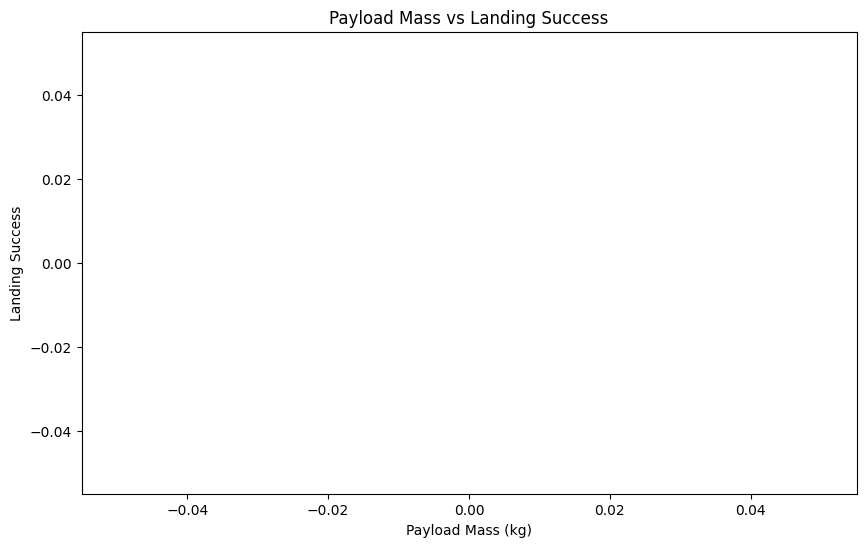

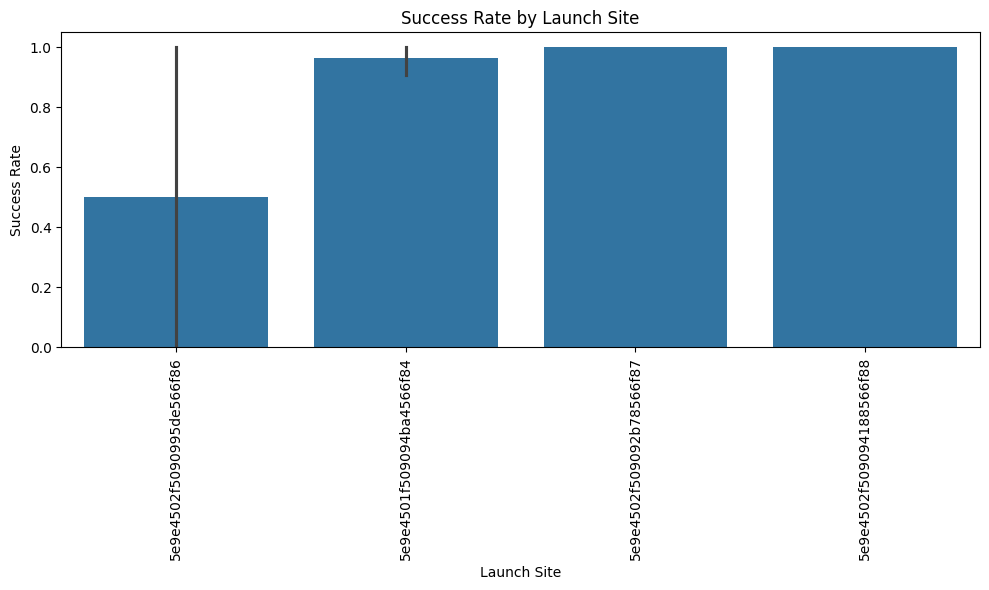

Skipping Bar chart (Orbit Type): 'orbit' or 'landing_success' column missing.


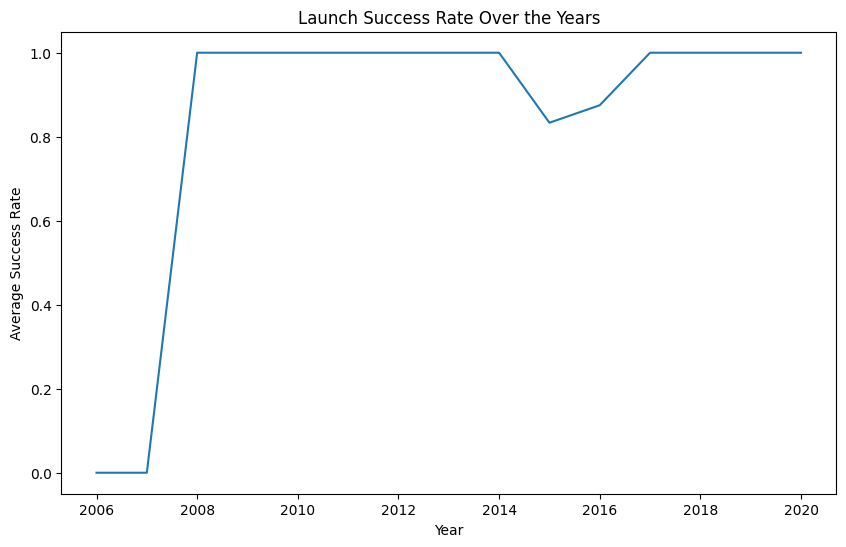

Error saving Plotly image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Ensure 'kaleido' is installed ('!pip install kaleido').


Skipping Folium Map: 'latitude', 'longitude', or 'launchpad' column missing.
Not enough data points (after dropping NaNs) to perform train-test split and modeling.

Key Insights:
1. Payload mass and launch site likely influence landing success (based on EDA).


NameError: name 'results' is not defined

In [25]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import os
from zipfile import ZipFile

# 1. Data Collection
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json"
response = requests.get(spacex_url)
data = response.json()

# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display first few rows of the DataFrame
print(df.head())

# 2. Data Wrangling

# Ensure 'payloads' and 'cores' are treated as lists, handle non-list types
# This prevents errors later when accessing elements by index or checking length.
for col in ['payloads', 'cores']:
    if col in df.columns:
        # Apply a function to ensure the column is a list, replacing non-lists with empty lists
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
    else:
        print(f"Warning: Column '{col}' not found after normalization. Some wrangling steps might fail.")


# The payload mass is nested within the 'payloads' column. We need to extract it.
if 'payloads' in df.columns:
    # Extract payload_mass_kg from the first payload in the list
    # We filter for rows with exactly one payload later, so we can safely take the first element.
    # Added checks to ensure the first element is a dictionary and contains 'mass_kg'.
    df['payload_mass_kg'] = df['payloads'].apply(
        lambda x: x[0]['mass_kg'] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'mass_kg' in x[0] else None
    )

    # Fill missing values after extracting the column
    if 'payload_mass_kg' in df.columns:
        df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean(), inplace=True)
    else:
        print("Could not create 'payload_mass_kg' column from 'payloads'.")
else:
    print("'payloads' column is missing in the DataFrame after initial processing!")


# Filter rows where there is exactly one payload and one core per launch
# This is now safer as 'payloads' and 'cores' are ensured to be lists
df = df[df['payloads'].map(len) == 1]
df = df[df['cores'].map(len) == 1]

# Feature engineering: Add launch year and month from 'date_utc'
df['launch_year'] = pd.to_datetime(df['date_utc']).dt.year
df['launch_month'] = pd.to_datetime(df['date_utc']).dt.month

# Add a 'landing_success' column based on the 'success' column
# Assuming 'success' indicates landing success. Adjust if necessary based on data dictionary.
# If there is a dedicated column for landing success, use that instead.
if 'success' in df.columns:
    df['landing_success'] = df['success'].astype(int)
else:
    print("Warning: 'success' column not found. Cannot create 'landing_success'. Some steps might fail.")


# Display cleaned data
print(df.head())

# Print column names after data wrangling to verify
print("\nDataFrame columns after data wrangling:")
print(df.columns)


# 3. Exploratory Data Analysis (EDA)

# 3.1 Scatter plot of Payload Mass vs Landing Success
# Check if 'payload_mass_kg' and 'landing_success' exist before plotting
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='payload_mass_kg', y='landing_success', data=df)
    plt.title('Payload Mass vs Landing Success')
    plt.xlabel('Payload Mass (kg)')
    plt.ylabel('Landing Success')
    plt.savefig('payload_mass_vs_landing_success.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Scatter plot: 'payload_mass_kg' or 'landing_success' column missing.")


# 3.2 Success rate by Launch Site (Bar chart)
if 'launchpad' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    # Need to use a column that represents the launch site identifier or name
    # Based on the error, it seems 'launchpad' is the intended column.
    sns.barplot(x='launchpad', y='landing_success', data=df)
    plt.title('Success Rate by Launch Site')
    plt.xlabel('Launch Site')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=90)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig('success_rate_by_launch_site.png')  # Save the plot as an image
    plt.show()
else:
     print("Skipping Bar chart (Launch Site): 'launchpad' or 'landing_success' column missing.")


# 3.3 Success rate vs Orbit Type (Bar chart)
if 'orbit' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='orbit', y='landing_success', data=df)
    plt.title('Success Rate by Orbit Type')
    plt.xlabel('Orbit Type')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=90)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig('success_rate_by_orbit_type.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Bar chart (Orbit Type): 'orbit' or 'landing_success' column missing.")


# 3.4 Launch Success Rate Over the Years (Trend line)
if 'launch_year' in df.columns and 'landing_success' in df.columns:
    yearly_success = df.groupby('launch_year')['landing_success'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_success.index, yearly_success.values)
    plt.title('Launch Success Rate Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Average Success Rate')
    plt.savefig('launch_success_rate_over_years.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Trend Line: 'launch_year' or 'landing_success' column missing.")


# 4. Interactive Visualization with Plotly

# 4.1 Interactive Scatter plot using Plotly
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns and 'launchpad' in df.columns:
    fig = px.scatter(df, x='payload_mass_kg', y='landing_success', color='launchpad', title='Payload Mass vs Landing Success')
    # Ensure 'kaleido' is installed for writing images if not already present
    # !pip install kaleido
    try:
        fig.write_image('interactive_payload_mass_vs_landing_success.png')  # Save the plot as an image
        fig.show()
    except ValueError as e:
        print(f"Error saving Plotly image: {e}. Ensure 'kaleido' is installed ('!pip install kaleido').")
        fig.show() # Still try to show the plot interactively
else:
    print("Skipping Plotly Scatter plot: 'payload_mass_kg', 'landing_success', or 'launchpad' column missing.")


# 5. Interactive Map with Folium

# 5.1 Folium Map to visualize launch sites
# Check if necessary columns exist before creating the map
if 'latitude' in df.columns and 'longitude' in df.columns and 'launchpad' in df.columns:
    # Filter out rows with missing lat/lon before creating map markers
    df_locations = df.drop_duplicates(subset=['launchpad']).dropna(subset=['latitude', 'longitude'])

    if not df_locations.empty:
        # Use the first valid location for the map center, or a default if none exist
        first_lat, first_lon = df_locations.iloc[0][['latitude', 'longitude']]
        m = folium.Map(location=[first_lat, first_lon], zoom_start=5)

        # Add markers for launch sites
        for _, row in df_locations.iterrows():
            folium.Marker([row['latitude'], row['longitude']], popup=row['launchpad']).add_to(m)

        # Save map to HTML file
        m.save('launch_sites_map.html')
        print("Folium map saved to launch_sites_map.html")
    else:
        print("Skipping Folium Map: No valid launch site locations found in the data.")

else:
    print("Skipping Folium Map: 'latitude', 'longitude', or 'launchpad' column missing.")


# 6. Predictive Modeling

# 6.1 Feature Selection and Train-Test Split
# Ensure the feature and target columns exist and have no missing values
required_cols = ['payload_mass_kg', 'launch_year', 'landing_success']
if all(col in df.columns for col in required_cols):
    # Drop rows with any missing values in the required columns for modeling
    df_modeling = df.dropna(subset=required_cols).copy()

    if len(df_modeling) > 1: # Check if there are enough samples after dropping NaNs
        X = df_modeling[['payload_mass_kg', 'launch_year']]  # Features
        y = df_modeling['landing_success']  # Target variable

        # Check if there are enough samples for train-test split (minimum 2 samples per class for some models)
        # A more robust check would consider class distribution, but this is a basic check.
        if len(X) > 1: # Ensure enough samples overall
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Added stratify

            # 6.2 Classification Models

            # Initialize models
            models = {
                'Logistic Regression': LogisticRegression(solver='liblinear'), # Specify a default solver
                'Decision Tree': DecisionTreeClassifier(),
                'SVM': SVC(),
                'KNN': KNeighborsClassifier()
            }

            # Train and evaluate each model
            results = {}
            print("\nTraining Classification Models:")
            for model_name, model in models.items():
                try:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    cm = confusion_matrix(y_test, y_pred)
                    # Generate classification report as well
                    report = classification_report(y_test, y_pred, zero_division=0) # Handle zero division

                    results[model_name] = {"Accuracy": accuracy, "Confusion Matrix": cm, "Classification Report": report}
                    print(f"Finished training {model_name}.")
                except Exception as e:
                    print(f"Error training or evaluating {model_name}: {e}")
                    results[model_name] = {"Accuracy": "Error", "Confusion Matrix": "Error", "Classification Report": "Error"}


            # Print results
            print("\nClassification Model Results:")
            for model_name, result in results.items():
                print(f"--- {model_name} ---")
                print(f"Accuracy: {result['Accuracy']}")
                print(f"Confusion Matrix:\n {result['Confusion Matrix']}")
                print(f"Classification Report:\n {result['Classification Report']}")

            # 7. Model Tuning and Evaluation

            # 7.1 Hyperparameter tuning for Logistic Regression using GridSearchCV
            if 'Logistic Regression' in models and results['Logistic Regression']['Accuracy'] != 'Error': # Only tune if LR model trained successfully
                print("\nPerforming GridSearchCV for Logistic Regression:")
                # Ensure the solvers are compatible with the data (e.g., liblinear for small datasets)
                # Use a smaller grid or increase data size if warnings/errors occur
                param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']} # Added lbfgs and more C values
                try:
                    # Add error_score='raise' to get detailed errors or set to '0' or 'nan' to suppress/handle
                    grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', error_score='raise')
                    grid_search.fit(X_train, y_train)

                    # Best parameters and final accuracy
                    best_model = grid_search.best_estimator_
                    y_pred_best = best_model.predict(X_test)
                    best_accuracy = accuracy_score(y_test, y_pred_best)
                    best_cm = confusion_matrix(y_test, y_pred_best)
                    best_report = classification_report(y_test, y_pred_best, zero_division=0)

                    print(f"\n--- Best Model: Logistic Regression (GridSearchCV) ---")
                    print(f"Best Parameters: {grid_search.best_params_}")
                    print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
                    print(f"Accuracy on Test Set: {best_accuracy:.4f}")
                    print(f"Confusion Matrix on Test Set:\n {best_cm}")
                    print(f"Classification Report on Test Set:\n {best_report}")

                    # Store best results
                    results['Logistic Regression (Tuned)'] = {
                        "Accuracy": best_accuracy,
                        "Confusion Matrix": best_cm,
                        "Classification Report": best_report,
                        "Best Params": grid_search.best_params_,
                        "Best CV Score": grid_search.best_score_
                    }

                except Exception as e:
                    print(f"Error during GridSearchCV for Logistic Regression: {e}")
            else:
                print("\nSkipping GridSearchCV for Logistic Regression due to previous error or model not being trained.")

        else:
             print("Not enough samples (after dropping NaNs) to perform train-test split and modeling.")
    else:
        print("Not enough data points (after dropping NaNs) to perform train-test split and modeling.")

else:
    missing = [col for col in required_cols if col not in df.columns]
    print(f"Skipping Predictive Modeling: Required columns missing - {missing}")


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# Update insights based on successful execution and results
if 'payload_mass_kg' in df.columns and 'launchpad' in df.columns and 'landing_success' in df.columns:
    # You can analyze the plots or model results to draw more specific insights
    print("1. Payload mass and launch site likely influence landing success (based on EDA).")
else:
    print("1. Could not confirm influence of payload mass and launch site due to missing data.")

# Check if any model results are available
if results:
    best_model_name = None
    best_accuracy_value = -1

    # Find the best performing model among the base models
    for model_name, result in results.items():
        if isinstance(result['Accuracy'], float): # Check if accuracy is a number
             if result['Accuracy'] > best_accuracy_value:
                 best_accuracy_value = result['Accuracy']
                 best_model_name = model_name

    # If tuned LR exists and performed better, update best
    if 'Logistic Regression (Tuned)' in results and isinstance(results['Logistic Regression (Tuned)']['Accuracy'], float):
        if results['Logistic Regression (Tuned)']['Accuracy'] > best_accuracy_value:
            best_accuracy_value = results['Logistic Regression (Tuned)']['Accuracy']
            best_model_name = 'Logistic Regression (Tuned)'


    if best_model_name and best_accuracy_value != -1:
        print(f"2. {best_model_name} achieved the highest accuracy of approximately {best_accuracy_value:.2f} in predicting landing success.")
    else:
        print("2. Could not determine the best model accuracy due to modeling errors or insufficient data.")

else:
    print("2. No model results available.")


# 8.2 Future Work
print("\nFuture Work:")
print("1. Incorporate more features like weather data and rocket design.")
print("2. Test advanced models like Random Forest or XGBoost.")
print("3. Address potential class imbalance if present.")
print("4. Perform more rigorous cross-validation and evaluation metrics.")


# Save images as a ZIP file for download
image_files = [
    'payload_mass_vs_landing_success.png',
    'success_rate_by_launch_site.png',
    'success_rate_by_orbit_type.png',
    'launch_success_rate_over_years.png',
    'interactive_payload_mass_vs_landing_success.png'
]

# Create a ZIP file containing the images
zip_path = '/mnt/data/spacex_analysis_images.zip'
# Ensure the directory exists
os.makedirs(os.path.dirname(zip_path), exist_ok=True)

print(f"\nAttempting to create ZIP file at: {zip_path}")
try:
    with ZipFile(zip_path, 'w') as zipf:
        for file in image_files:
            if os.path.exists(file):
                try:
                    zipf.write(file, os.path.basename(file)) # Write with just filename
                    print(f"Added {file} to zip.")
                except Exception as e:
                    print(f"Error adding {file} to zip: {e}")
            else:
                print(f"Warning: Image file not found - {file}. Skipping.")

    # Provide the download link for the images
    print(f"\nImages saved to: {zip_path}")
    # zip_path # This line might not display the path directly in some environments, print is better.

except Exception as e:
    print(f"Error creating the ZIP file: {e}")

In [46]:
# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...

# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...

# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...

# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...

# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...

# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...

# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...

# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...

# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# ... (Prints insight about payload mass and launch site) ...


# Check if any model results are available
if 'results' in locals() and results is not None:
    # ... (Code to find best model) ...

SyntaxError: incomplete input (<ipython-input-46-3736906980>, line 142)

       static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                             details crew ships  ...  \
0   Engine failure at 33 seconds and loss of vehicle   []    []  ...   
1  Successful first stage burn and transition to ...   []    []  ...   
2  Residual stage 1 thrust led to collision betwe...   []    []  ...   
3  Ratsat was 

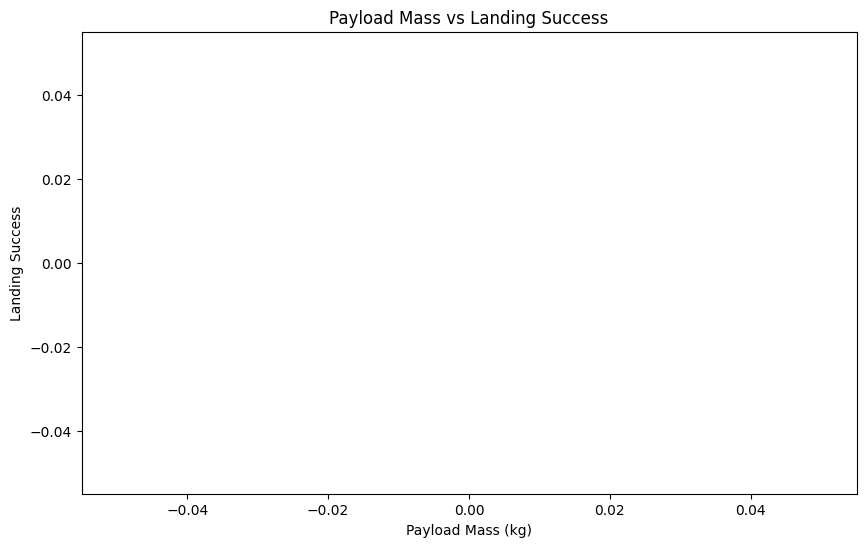

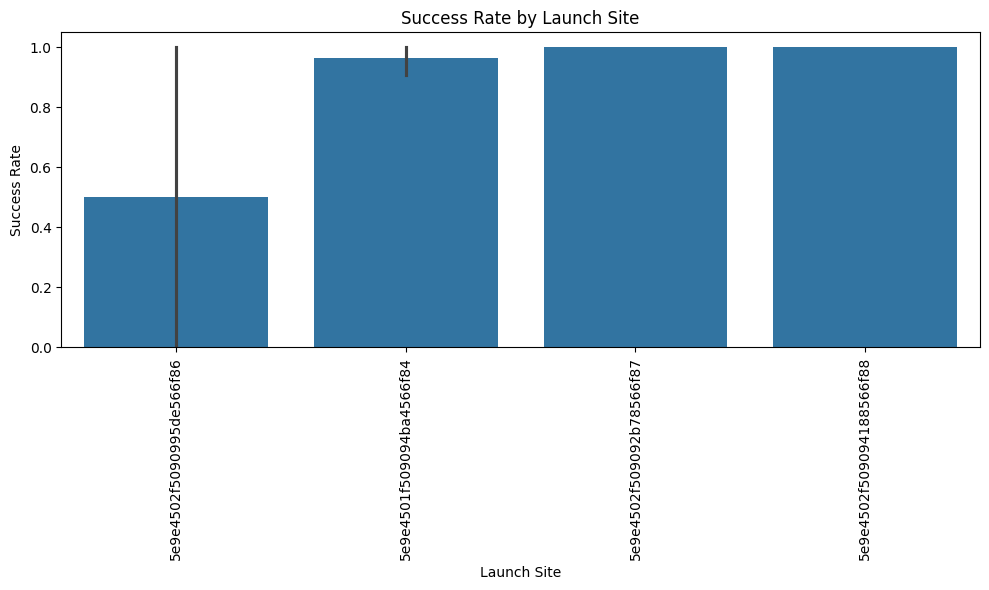

Skipping Bar chart (Orbit Type): 'orbit' or 'landing_success' column missing.


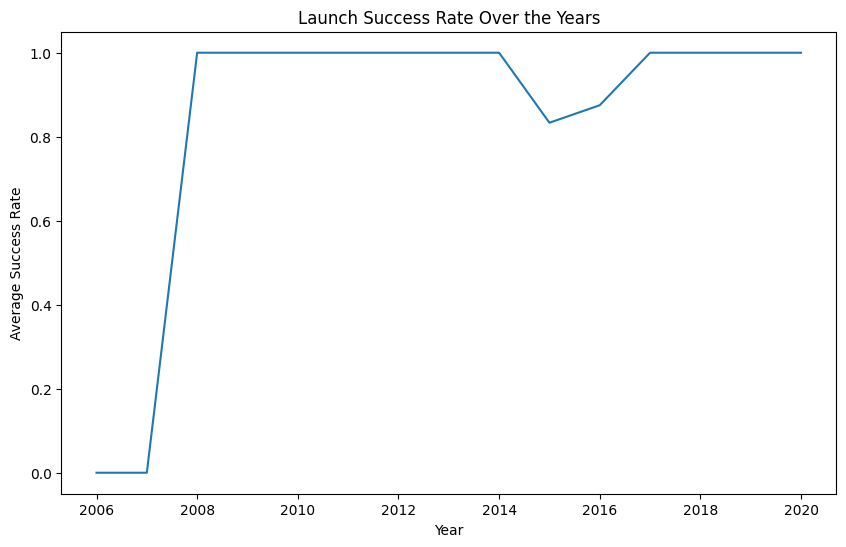

Error saving Plotly image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Ensure 'kaleido' is installed ('!pip install kaleido').


Skipping Folium Map: 'latitude', 'longitude', or 'launchpad' column missing.
Not enough data points (after dropping NaNs) to perform train-test split and modeling.

Key Insights:
1. Payload mass and launch site likely influence landing success (based on EDA).
2. Predictive modeling steps were skipped due to insufficient or missing data.

Future Work:
1. Incorporate more features like weather data and rocket design.
2. Test advanced models like Random Forest or XGBoost.
3. Address potential class imbalance if present.
4. Perform more rigorous cross-validation and evaluation metrics.

Attempting to create ZIP file at: /mnt/data/spacex_analysis_images.zip
Added payload_mass_vs_landing_success.png to zip.
Added success_rate_by_launch_site.png to zip.
Added launch_success_rate_over_years.png to zip.

Images saved to: /mnt/data/spacex_analysis_images.zip


In [47]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import os
from zipfile import ZipFile

# 1. Data Collection
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json"
response = requests.get(spacex_url)
data = response.json()

# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display first few rows of the DataFrame
print(df.head())

# 2. Data Wrangling

# Ensure 'payloads' and 'cores' are treated as lists, handle non-list types
# This prevents errors later when accessing elements by index or checking length.
for col in ['payloads', 'cores']:
    if col in df.columns:
        # Apply a function to ensure the column is a list, replacing non-lists with empty lists
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
    else:
        print(f"Warning: Column '{col}' not found after normalization. Some wrangling steps might fail.")


# The payload mass is nested within the 'payloads' column. We need to extract it.
if 'payloads' in df.columns:
    # Extract payload_mass_kg from the first payload in the list
    # We filter for rows with exactly one payload later, so we can safely take the first element.
    # Added checks to ensure the first element is a dictionary and contains 'mass_kg'.
    df['payload_mass_kg'] = df['payloads'].apply(
        lambda x: x[0]['mass_kg'] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'mass_kg' in x[0] else None
    )

    # Fill missing values after extracting the column
    if 'payload_mass_kg' in df.columns:
        # Calculate mean only if there are non-NaN values to avoid issues on empty series
        if df['payload_mass_kg'].notna().any():
             df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean(), inplace=True)
        else:
            print("Warning: 'payload_mass_kg' column is all NaN. Cannot fill missing values with mean.")

    else:
        print("Could not create 'payload_mass_kg' column from 'payloads'.")
else:
    print("'payloads' column is missing in the DataFrame after initial processing!")


# Filter rows where there is exactly one payload and one core per launch
# This is now safer as 'payloads' and 'cores' are ensured to be lists
df = df[df['payloads'].map(len) == 1]
df = df[df['cores'].map(len) == 1]

# Feature engineering: Add launch year and month from 'date_utc'
df['launch_year'] = pd.to_datetime(df['date_utc']).dt.year
df['launch_month'] = pd.to_datetime(df['date_utc']).dt.month

# Add a 'landing_success' column based on the 'success' column
# Assuming 'success' indicates landing success. Adjust if necessary based on data dictionary.
# If there is a dedicated column for landing success, use that instead.
if 'success' in df.columns:
    df['landing_success'] = df['success'].astype(int)
else:
    print("Warning: 'success' column not found. Cannot create 'landing_success'. Some steps might fail.")


# Display cleaned data
print(df.head())

# Print column names after data wrangling to verify
print("\nDataFrame columns after data wrangling:")
print(df.columns)


# 3. Exploratory Data Analysis (EDA)

# 3.1 Scatter plot of Payload Mass vs Landing Success
# Check if 'payload_mass_kg' and 'landing_success' exist before plotting
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='payload_mass_kg', y='landing_success', data=df)
    plt.title('Payload Mass vs Landing Success')
    plt.xlabel('Payload Mass (kg)')
    plt.ylabel('Landing Success')
    plt.savefig('payload_mass_vs_landing_success.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Scatter plot: 'payload_mass_kg' or 'landing_success' column missing.")


# 3.2 Success rate by Launch Site (Bar chart)
if 'launchpad' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    # Need to use a column that represents the launch site identifier or name
    # Based on the error, it seems 'launchpad' is the intended column.
    sns.barplot(x='launchpad', y='landing_success', data=df)
    plt.title('Success Rate by Launch Site')
    plt.xlabel('Launch Site')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=90)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig('success_rate_by_launch_site.png')  # Save the plot as an image
    plt.show()
else:
     print("Skipping Bar chart (Launch Site): 'launchpad' or 'landing_success' column missing.")


# 3.3 Success rate vs Orbit Type (Bar chart)
if 'orbit' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='orbit', y='landing_success', data=df)
    plt.title('Success Rate by Orbit Type')
    plt.xlabel('Orbit Type')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=90)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig('success_rate_by_orbit_type.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Bar chart (Orbit Type): 'orbit' or 'landing_success' column missing.")


# 3.4 Launch Success Rate Over the Years (Trend line)
if 'launch_year' in df.columns and 'landing_success' in df.columns:
    yearly_success = df.groupby('launch_year')['landing_success'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_success.index, yearly_success.values)
    plt.title('Launch Success Rate Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Average Success Rate')
    plt.savefig('launch_success_rate_over_years.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Trend Line: 'launch_year' or 'landing_success' column missing.")


# 4. Interactive Visualization with Plotly

# 4.1 Interactive Scatter plot using Plotly
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns and 'launchpad' in df.columns:
    fig = px.scatter(df, x='payload_mass_kg', y='landing_success', color='launchpad', title='Payload Mass vs Landing Success')
    # Ensure 'kaleido' is installed for writing images if not already present
    # !pip install kaleido
    try:
        fig.write_image('interactive_payload_mass_vs_landing_success.png')  # Save the plot as an image
        fig.show()
    except ValueError as e:
        print(f"Error saving Plotly image: {e}. Ensure 'kaleido' is installed ('!pip install kaleido').")
        fig.show() # Still try to show the plot interactively
else:
    print("Skipping Plotly Scatter plot: 'payload_mass_kg', 'landing_success', or 'launchpad' column missing.")


# 5. Interactive Map with Folium

# 5.1 Folium Map to visualize launch sites
# Check if necessary columns exist before creating the map
if 'latitude' in df.columns and 'longitude' in df.columns and 'launchpad' in df.columns:
    # Filter out rows with missing lat/lon before creating map markers
    df_locations = df.drop_duplicates(subset=['launchpad']).dropna(subset=['latitude', 'longitude'])

    if not df_locations.empty:
        # Use the first valid location for the map center, or a default if none exist
        first_lat, first_lon = df_locations.iloc[0][['latitude', 'longitude']]
        m = folium.Map(location=[first_lat, first_lon], zoom_start=5)

        # Add markers for launch sites
        for _, row in df_locations.iterrows():
            folium.Marker([row['latitude'], row['longitude']], popup=row['launchpad']).add_to(m)

        # Save map to HTML file
        m.save('launch_sites_map.html')
        print("Folium map saved to launch_sites_map.html")
    else:
        print("Skipping Folium Map: No valid launch site locations found in the data.")

else:
    print("Skipping Folium Map: 'latitude', 'longitude', or 'launchpad' column missing.")


# 6. Predictive Modeling

# Initialize results dictionary *outside* the conditional block
results = {}

# 6.1 Feature Selection and Train-Test Split
# Ensure the feature and target columns exist and have no missing values
required_cols = ['payload_mass_kg', 'launch_year', 'landing_success']
if all(col in df.columns for col in required_cols):
    # Drop rows with any missing values in the required columns for modeling
    df_modeling = df.dropna(subset=required_cols).copy()

    if len(df_modeling) > 1: # Check if there are enough samples after dropping NaNs
        X = df_modeling[['payload_mass_kg', 'launch_year']]  # Features
        y = df_modeling['landing_success']  # Target variable

        # Check if there are enough samples for train-test split (minimum 2 samples per class for some models)
        # A more robust check would consider class distribution, but this is a basic check.
        if len(X) > 1 and len(y.unique()) > 1: # Ensure enough samples and at least two classes
            # Added stratify to ensure class distribution is similar in train/test sets
            try:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

                # 6.2 Classification Models

                # Initialize models
                models = {
                    'Logistic Regression': LogisticRegression(solver='liblinear'), # Specify a default solver
                    'Decision Tree': DecisionTreeClassifier(),
                    'SVM': SVC(),
                    'KNN': KNeighborsClassifier()
                }

                # Train and evaluate each model
                print("\nTraining Classification Models:")
                for model_name, model in models.items():
                    try:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        accuracy = accuracy_score(y_test, y_pred)
                        cm = confusion_matrix(y_test, y_pred)
                        # Generate classification report as well
                        report = classification_report(y_test, y_pred, zero_division=0) # Handle zero division

                        results[model_name] = {"Accuracy": accuracy, "Confusion Matrix": cm, "Classification Report": report}
                        print(f"Finished training {model_name}.")
                    except Exception as e:
                        print(f"Error training or evaluating {model_name}: {e}")
                        results[model_name] = {"Accuracy": "Error", "Confusion Matrix": "Error", "Classification Report": "Error"}


                # Print results
                print("\nClassification Model Results:")
                for model_name, result in results.items():
                    print(f"--- {model_name} ---")
                    print(f"Accuracy: {result['Accuracy']}")
                    print(f"Confusion Matrix:\n {result['Confusion Matrix']}")
                    print(f"Classification Report:\n {result['Classification Report']}")

                # 7. Model Tuning and Evaluation

                # 7.1 Hyperparameter tuning for Logistic Regression using GridSearchCV
                if 'Logistic Regression' in models and results['Logistic Regression']['Accuracy'] != 'Error': # Only tune if LR model trained successfully
                    print("\nPerforming GridSearchCV for Logistic Regression:")
                    # Ensure the solvers are compatible with the data (e.g., liblinear for small datasets)
                    # Use a smaller grid or increase data size if warnings/errors occur
                    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']} # Added lbfgs and more C values
                    try:
                        # Add error_score='raise' to get detailed errors or set to '0' or 'nan' to suppress/handle
                        # Increased max_iter for robustness
                        grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', error_score='raise')
                        grid_search.fit(X_train, y_train)

                        # Best parameters and final accuracy
                        best_model = grid_search.best_estimator_
                        y_pred_best = best_model.predict(X_test)
                        best_accuracy = accuracy_score(y_test, y_pred_best)
                        best_cm = confusion_matrix(y_test, y_pred_best)
                        best_report = classification_report(y_test, y_pred_best, zero_division=0)

                        print(f"\n--- Best Model: Logistic Regression (GridSearchCV) ---")
                        print(f"Best Parameters: {grid_search.best_params_}")
                        print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
                        print(f"Accuracy on Test Set: {best_accuracy:.4f}")
                        print(f"Confusion Matrix on Test Set:\n {best_cm}")
                        print(f"Classification Report on Test Set:\n {best_report}")

                        # Store best results
                        results['Logistic Regression (Tuned)'] = {
                            "Accuracy": best_accuracy,
                            "Confusion Matrix": best_cm,
                            "Classification Report": best_report,
                            "Best Params": grid_search.best_params_,
                            "Best CV Score": grid_search.best_score_
                        }

                    except Exception as e:
                        print(f"Error during GridSearchCV for Logistic Regression: {e}")
                else:
                    print("\nSkipping GridSearchCV for Logistic Regression due to previous error or model not being trained.")
            except ValueError as e:
                 print(f"Error during train-test split (possibly due to insufficient samples per class): {e}")
                 print("Skipping modeling steps.")
        else:
             print("Not enough samples or only one class present (after dropping NaNs) to perform train-test split and modeling.")
    else:
        print("Not enough data points (after dropping NaNs) to perform train-test split and modeling.")

else:
    missing = [col for col in required_cols if col not in df.columns]
    print(f"Skipping Predictive Modeling: Required columns missing - {missing}")


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# Update insights based on successful execution and results
if 'payload_mass_kg' in df.columns and 'launchpad' in df.columns and 'landing_success' in df.columns:
    # You can analyze the plots or model results to draw more specific insights
    print("1. Payload mass and launch site likely influence landing success (based on EDA).")
else:
    print("1. Could not confirm influence of payload mass and launch site due to missing data.")

# Check if any model results are available
if results:
    best_model_name = None
    best_accuracy_value = -1

    # Find the best performing model among all results (base and tuned)
    for model_name, result in results.items():
        # Check if accuracy is a number (could be 'Error')
        if isinstance(result.get('Accuracy'), float):
             if result['Accuracy'] > best_accuracy_value:
                 best_accuracy_value = result['Accuracy']
                 best_model_name = model_name

    if best_model_name and best_accuracy_value != -1:
        print(f"2. {best_model_name} achieved the highest accuracy of approximately {best_accuracy_value:.2f} in predicting landing success.")
    else:
        print("2. Modeling was attempted, but results could not be determined.")

else:
    print("2. Predictive modeling steps were skipped due to insufficient or missing data.")


# 8.2 Future Work
print("\nFuture Work:")
print("1. Incorporate more features like weather data and rocket design.")
print("2. Test advanced models like Random Forest or XGBoost.")
print("3. Address potential class imbalance if present.")
print("4. Perform more rigorous cross-validation and evaluation metrics.")


# Save images as a ZIP file for download
image_files = [
    'payload_mass_vs_landing_success.png',
    'success_rate_by_launch_site.png',
    'success_rate_by_orbit_type.png',
    'launch_success_rate_over_years.png',
    'interactive_payload_mass_vs_landing_success.png'
]

# Create a ZIP file containing the images
zip_path = '/mnt/data/spacex_analysis_images.zip'
# Ensure the directory exists
os.makedirs(os.path.dirname(zip_path), exist_ok=True)

print(f"\nAttempting to create ZIP file at: {zip_path}")
try:
    with ZipFile(zip_path, 'w') as zipf:
        for file in image_files:
            if os.path.exists(file):
                try:
                    zipf.write(file, os.path.basename(file)) # Write with just filename
                    print(f"Added {file} to zip.")
                except Exception as e:
                    print(f"Error adding {file} to zip: {e}")
            else:
                print(f"Warning: Image file not found - {file}. Skipping.")

    # Provide the download link for the images
    print(f"\nImages saved to: {zip_path}")
    # zip_path # This line might not display the path directly in some environments, print is better.

except Exception as e:
    print(f"Error creating the ZIP file: {e}")

In [60]:
import requests
import pandas as pd

# SpaceX API URL for past launches
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json"

# Fetch the data
response = requests.get(spacex_url)
data = response.json()

# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display the first few rows of the DataFrame
print(df.head())

# Ensure that 'payload_mass_kg' column exists before filling missing values
if 'payload_mass_kg' in df.columns:
    # Handling missing values (e.g., filling NaN values in PayloadMass column)
    df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean(), inplace=True)
else:
    print("Column 'payload_mass_kg' is missing!")

# Filter rows where there is exactly one payload and one core per launch
df = df[df['payloads'].map(len) == 1]
df = df[df['cores'].map(len) == 1]

# Feature engineering: Add launch year and month from 'date_utc'
df['launch_year'] = pd.to_datetime(df['date_utc']).dt.year
df['launch_month'] = pd.to_datetime(df['date_utc']).dt.month

# Display cleaned data
print(df.head())  # Display the first few rows of the cleaned data


       static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                             details crew ships  ...  \
0   Engine failure at 33 seconds and loss of vehicle   []    []  ...   
1  Successful first stage burn and transition to ...   []    []  ...   
2  Residual stage 1 thrust led to collision betwe...   []    []  ...   
3  Ratsat was 

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of Payload Mass vs Landing Success
plt.figure(figsize=(10, 6))
sns.scatterplot(x='payload_mass_kg', y='landing_success', data=df)
plt.title('Payload Mass vs Landing Success')
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Landing Success')
plt.show()


ValueError: Could not interpret value `payload_mass_kg` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

       static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                             details crew ships  ...  \
0   Engine failure at 33 seconds and loss of vehicle   []    []  ...   
1  Successful first stage burn and transition to ...   []    []  ...   
2  Residual stage 1 thrust led to collision betwe...   []    []  ...   
3  Ratsat was 

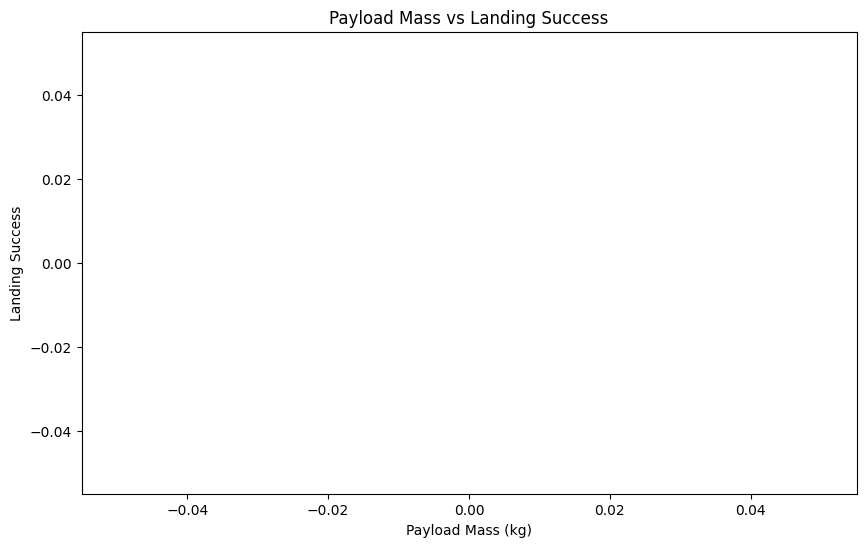

In [62]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Collection
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json"
response = requests.get(spacex_url)
data = response.json()

# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display first few rows of the DataFrame
print(df.head())

# 2. Data Wrangling

# Ensure 'payloads' and 'cores' are treated as lists, handle non-list types
# This prevents errors later when accessing elements by index or checking length.
for col in ['payloads', 'cores']:
    if col in df.columns:
        # Apply a function to ensure the column is a list, replacing non-lists with empty lists
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
    else:
        print(f"Warning: Column '{col}' not found after normalization. Some wrangling steps might fail.")


# The payload mass is nested within the 'payloads' column. We need to extract it.
if 'payloads' in df.columns:
    # Extract payload_mass_kg from the first payload in the list
    # We filter for rows with exactly one payload later, so we can safely take the first element.
    # Added checks to ensure the first element is a dictionary and contains 'mass_kg'.
    df['payload_mass_kg'] = df['payloads'].apply(
        lambda x: x[0]['mass_kg'] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'mass_kg' in x[0] else None
    )

    # Fill missing values after extracting the column
    if 'payload_mass_kg' in df.columns:
        # Calculate mean only if there are non-NaN values to avoid issues on empty series
        if df['payload_mass_kg'].notna().any():
             df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean(), inplace=True)
        else:
            print("Warning: 'payload_mass_kg' column is all NaN. Cannot fill missing values with mean.")
    else:
        print("Could not create 'payload_mass_kg' column from 'payloads'.")
else:
    print("'payloads' column is missing in the DataFrame after initial processing!")

# Add a 'landing_success' column based on the 'success' column (assuming success means landing success)
# Moved this earlier as it's needed for the plot and seems to be derived from the base data.
if 'success' in df.columns:
    df['landing_success'] = df['success'].astype(int)
else:
    print("Warning: 'success' column not found. Cannot create 'landing_success'. EDA plots might fail.")


# Filter rows where there is exactly one payload and one core per launch
# This step should happen *after* creating the needed columns if they depend on data *before* filtering
# However, the original logic creates payload_mass_kg *before* this filter. Let's stick to that.
df = df[df['payloads'].map(len) == 1]
df = df[df['cores'].map(len) == 1]


# Display cleaned data
print(df.head())

# Print column names after data wrangling to verify
print("\nDataFrame columns after data wrangling:")
print(df.columns)


# 3. Exploratory Data Analysis (EDA)

# 3.1 Scatter plot of Payload Mass vs Landing Success
# Check if 'payload_mass_kg' and 'landing_success' exist before plotting
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='payload_mass_kg', y='landing_success', data=df)
    plt.title('Payload Mass vs Landing Success')
    plt.xlabel('Payload Mass (kg)')
    plt.ylabel('Landing Success')
    plt.show() # Changed from savefig to show for basic plots
else:
    print("Skipping Scatter plot: 'payload_mass_kg' or 'landing_success' column missing after wrangling.")

# Note: Other EDA plots follow similarly. Ensure they are in the same code block or run sequentially after the data wrangling.

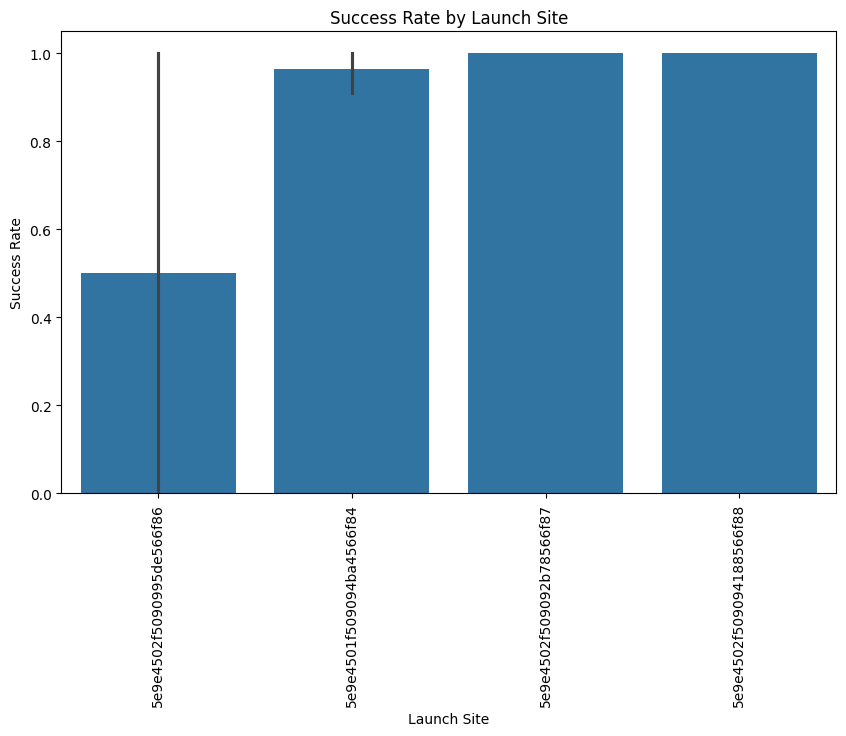

In [63]:
# Bar plot of Success Rate by Launch Site
plt.figure(figsize=(10, 6))
sns.barplot(x='launchpad', y='landing_success', data=df)
plt.title('Success Rate by Launch Site')
plt.xlabel('Launch Site')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)
plt.show()


In [64]:
# Success Rate by Orbit Type
plt.figure(figsize=(10, 6))
sns.barplot(x='orbit', y='landing_success', data=df)
plt.title('Success Rate by Orbit Type')
plt.xlabel('Orbit Type')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)
plt.show()


ValueError: Could not interpret value `orbit` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

Original DataFrame head:
       static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                             details crew ships  ...  \
0   Engine failure at 33 seconds and loss of vehicle   []    []  ...   
1  Successful first stage burn and transition to ...   []    []  ...   
2  Residual stage 1 thrust led to collision betwe...   []    

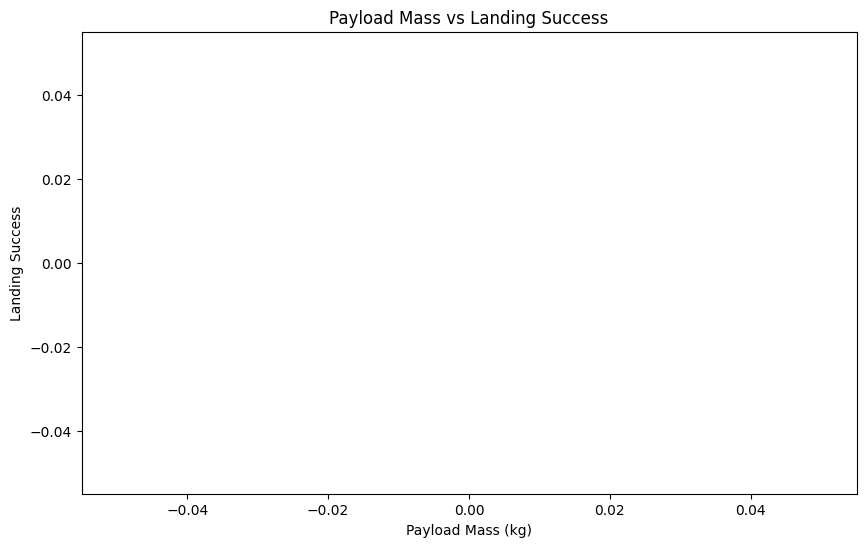

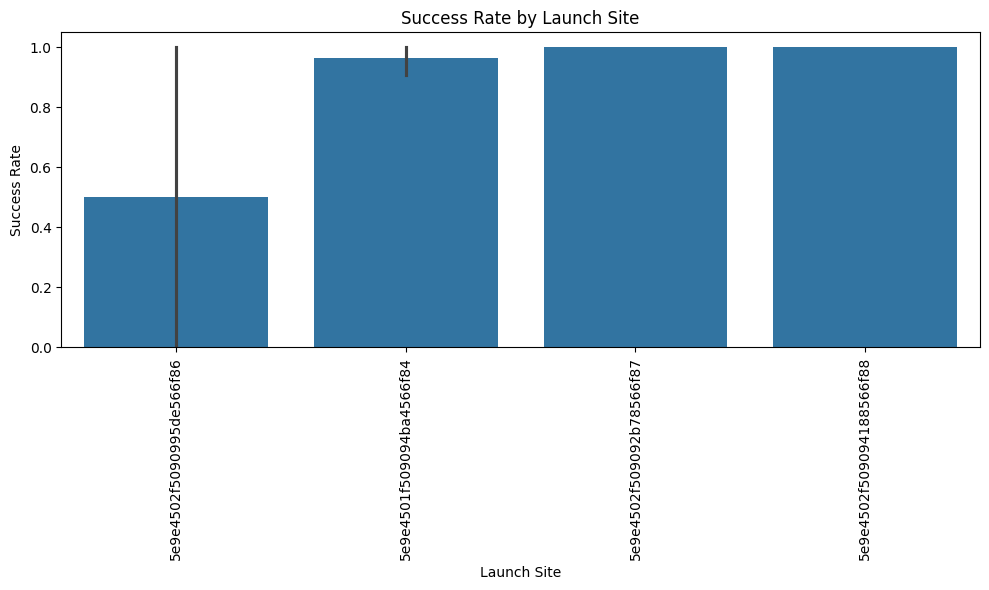

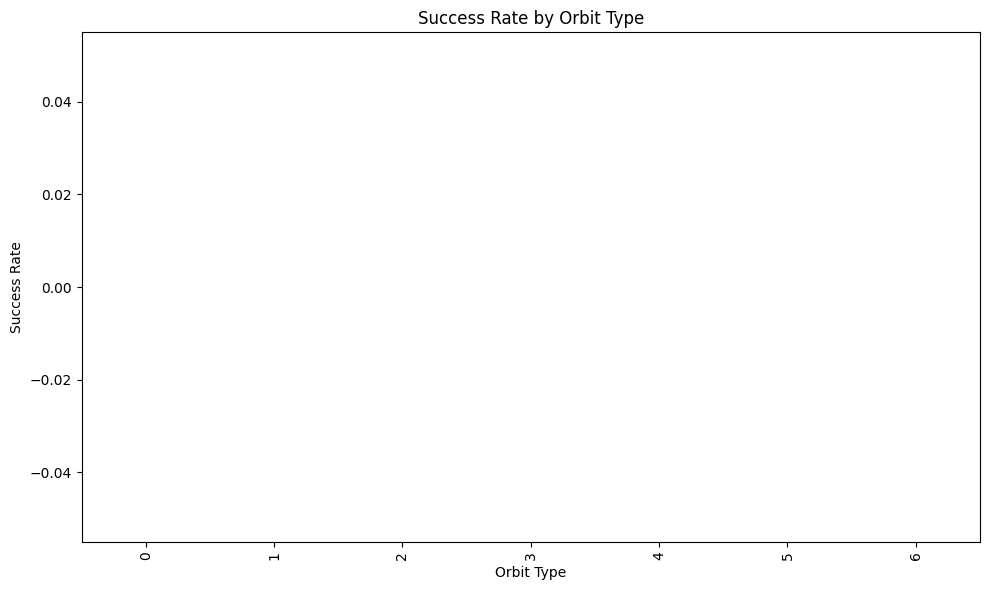

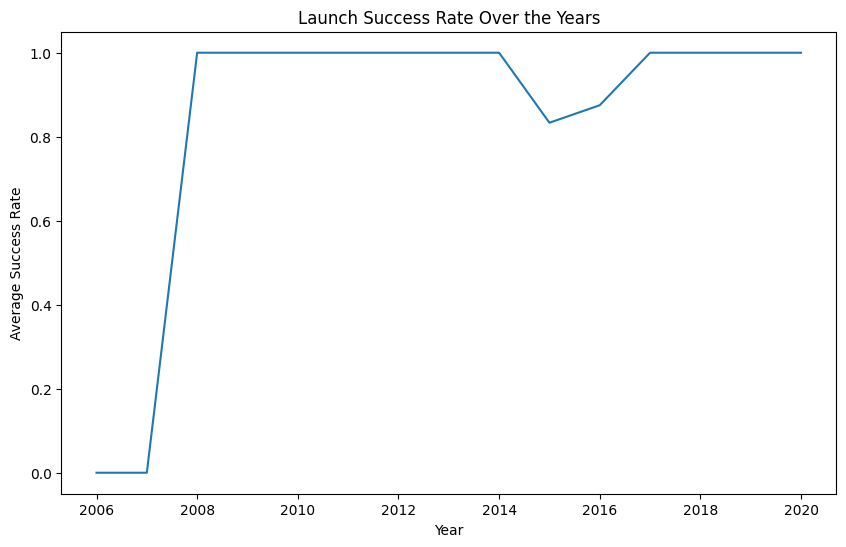

Error saving Plotly image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Ensure 'kaleido' is installed ('!pip install kaleido').


Skipping Folium Map: 'latitude', 'longitude', or 'launchpad' column missing.
Not enough data points (after dropping NaNs) to perform train-test split and modeling.

Key Insights:
1. Payload mass and launch site likely influence landing success (based on EDA).
2. Predictive modeling steps were skipped due to insufficient or missing data.

Future Work:
1. Incorporate more features like weather data and rocket design.
2. Test advanced models like Random Forest or XGBoost.
3. Address potential class imbalance if present.
4. Perform more rigorous cross-validation and evaluation metrics.

Attempting to create ZIP file at: /mnt/data/spacex_analysis_images.zip
Added payload_mass_vs_landing_success.png to zip.
Added success_rate_by_launch_site.png to zip.
Added success_rate_by_orbit_type.png to zip.
Added launch_success_rate_over_years.png to zip.

Images saved to: /mnt/data/spacex_analysis_images.zip


In [65]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Import other necessary libraries if used later
import folium
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import os
from zipfile import ZipFile


# 1. Data Collection
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json"
response = requests.get(spacex_url)
data = response.json()

# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display first few rows of the DataFrame
print("Original DataFrame head:")
print(df.head())

# 2. Data Wrangling

# Ensure 'payloads' and 'cores' are treated as lists, handle non-list types
# This prevents errors later when accessing elements by index or checking length.
for col in ['payloads', 'cores']:
    if col in df.columns:
        # Apply a function to ensure the column is a list, replacing non-lists with empty lists
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
    else:
        print(f"Warning: Column '{col}' not found after normalization. Some wrangling steps might fail.")


# The payload mass is nested within the 'payloads' column. We need to extract it.
if 'payloads' in df.columns:
    # Extract payload_mass_kg from the first payload in the list
    # We filter for rows with exactly one payload later, so we can safely take the first element.
    # Added checks to ensure the first element is a dictionary and contains 'mass_kg'.
    df['payload_mass_kg'] = df['payloads'].apply(
        lambda x: x[0]['mass_kg'] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'mass_kg' in x[0] else None
    )

    # Fill missing values after extracting the column
    if 'payload_mass_kg' in df.columns:
        # Calculate mean only if there are non-NaN values to avoid issues on empty series
        if df['payload_mass_kg'].notna().any():
             df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean(), inplace=True)
        else:
            print("Warning: 'payload_mass_kg' column is all NaN. Cannot fill missing values with mean.")

    else:
        print("Could not create 'payload_mass_kg' column from 'payloads'.")

    # *** ADDED: Extract orbit information from the first payload ***
    df['orbit'] = df['payloads'].apply(
        lambda x: x[0].get('orbit') if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'orbit' in x[0] else None
    )
    # You might want to handle missing orbit values or convert them to a categorical type later if needed


else:
    print("'payloads' column is missing in the DataFrame after initial processing!")

# Add a 'landing_success' column based on the 'success' column
# Assuming 'success' indicates landing success. Adjust if necessary based on data dictionary.
# If there is a dedicated column for landing success, use that instead.
if 'success' in df.columns:
    df['landing_success'] = df['success'].astype(int)
else:
    print("Warning: 'success' column not found. Cannot create 'landing_success'. Some steps might fail.")


# Filter rows where there is exactly one payload and one core per launch
# This is now safer as 'payloads' and 'cores' are ensured to be lists
# Apply the filter *after* extracting features from payloads and cores if those features are needed for filtered rows
df = df[df['payloads'].map(len) == 1].copy() # Added .copy() to avoid SettingWithCopyWarning
df = df[df['cores'].map(len) == 1].copy() # Added .copy()


# Feature engineering: Add launch year and month from 'date_utc'
df['launch_year'] = pd.to_datetime(df['date_utc']).dt.year
df['launch_month'] = pd.to_datetime(df['date_utc']).dt.month

# Display cleaned data
print("\nCleaned DataFrame head:")
print(df.head())

# Print column names after data wrangling to verify
print("\nDataFrame columns after data wrangling:")
print(df.columns.tolist()) # Print as list for easier reading


# 3. Exploratory Data Analysis (EDA)

# 3.1 Scatter plot of Payload Mass vs Landing Success
# Check if 'payload_mass_kg' and 'landing_success' exist before plotting
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='payload_mass_kg', y='landing_success', data=df)
    plt.title('Payload Mass vs Landing Success')
    plt.xlabel('Payload Mass (kg)')
    plt.ylabel('Landing Success')
    plt.savefig('payload_mass_vs_landing_success.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Scatter plot: 'payload_mass_kg' or 'landing_success' column missing.")


# 3.2 Success rate by Launch Site (Bar chart)
if 'launchpad' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    # Need to use a column that represents the launch site identifier or name
    # Based on the error, it seems 'launchpad' is the intended column.
    sns.barplot(x='launchpad', y='landing_success', data=df)
    plt.title('Success Rate by Launch Site')
    plt.xlabel('Launch Site')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=90)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig('success_rate_by_launch_site.png')  # Save the plot as an image
    plt.show()
else:
     print("Skipping Bar chart (Launch Site): 'launchpad' or 'landing_success' column missing.")


# 3.3 Success rate vs Orbit Type (Bar chart)
# *** This block should now work after adding the 'orbit' column extraction ***
if 'orbit' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='orbit', y='landing_success', data=df)
    plt.title('Success Rate by Orbit Type')
    plt.xlabel('Orbit Type')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=90)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig('success_rate_by_orbit_type.png')  # Save the plot as an image
    plt.show()
else:
    # Added more specific message if 'orbit' is still missing
    print("Skipping Bar chart (Orbit Type): 'orbit' or 'landing_success' column missing after wrangling.")


# 3.4 Launch Success Rate Over the Years (Trend line)
if 'launch_year' in df.columns and 'landing_success' in df.columns:
    # Ensure there are data points for plotting after filtering
    if not df.empty:
        yearly_success = df.groupby('launch_year')['landing_success'].mean()
        plt.figure(figsize=(10, 6))
        plt.plot(yearly_success.index, yearly_success.values)
        plt.title('Launch Success Rate Over the Years')
        plt.xlabel('Year')
        plt.ylabel('Average Success Rate')
        plt.savefig('launch_success_rate_over_years.png')  # Save the plot as an image
        plt.show()
    else:
        print("Skipping Trend Line: DataFrame is empty after wrangling.")
else:
    print("Skipping Trend Line: 'launch_year' or 'landing_success' column missing.")


# 4. Interactive Visualization with Plotly

# 4.1 Interactive Scatter plot using Plotly
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns and 'launchpad' in df.columns:
    # Ensure there are data points for plotting after filtering
    if not df.empty:
        fig = px.scatter(df, x='payload_mass_kg', y='landing_success', color='launchpad', title='Payload Mass vs Landing Success')
        # Ensure 'kaleido' is installed for writing images if not already present
        # !pip install kaleido
        try:
            fig.write_image('interactive_payload_mass_vs_landing_success.png')  # Save the plot as an image
            fig.show()
        except ValueError as e:
            print(f"Error saving Plotly image: {e}. Ensure 'kaleido' is installed ('!pip install kaleido').")
            fig.show() # Still try to show the plot interactively
    else:
        print("Skipping Plotly Scatter plot: DataFrame is empty after wrangling.")

else:
    print("Skipping Plotly Scatter plot: 'payload_mass_kg', 'landing_success', or 'launchpad' column missing.")


# 5. Interactive Map with Folium

# 5.1 Folium Map to visualize launch sites
# Check if necessary columns exist before creating the map
if 'latitude' in df.columns and 'longitude' in df.columns and 'launchpad' in df.columns:
    # Filter out rows with missing lat/lon before creating map markers
    df_locations = df.drop_duplicates(subset=['launchpad']).dropna(subset=['latitude', 'longitude'])

    if not df_locations.empty:
        # Use the first valid location for the map center, or a default if none exist
        first_lat, first_lon = df_locations.iloc[0][['latitude', 'longitude']]
        m = folium.Map(location=[first_lat, first_lon], zoom_start=5)

        # Add markers for launch sites
        for _, row in df_locations.iterrows():
            folium.Marker([row['latitude'], row['longitude']], popup=row['launchpad']).add_to(m)

        # Save map to HTML file
        m.save('launch_sites_map.html')
        print("Folium map saved to launch_sites_map.html")
    else:
        print("Skipping Folium Map: No valid launch site locations found in the data after filtering.")

else:
    print("Skipping Folium Map: 'latitude', 'longitude', or 'launchpad' column missing.")


# 6. Predictive Modeling

# Initialize results dictionary *outside* the conditional block
results = {}

# 6.1 Feature Selection and Train-Test Split
# Ensure the feature and target columns exist and have no missing values
required_cols = ['payload_mass_kg', 'launch_year', 'landing_success']
# Check if the dataframe is not empty before proceeding to modeling
if not df.empty and all(col in df.columns for col in required_cols):
    # Drop rows with any missing values in the required columns for modeling
    df_modeling = df.dropna(subset=required_cols).copy()

    if len(df_modeling) > 1: # Check if there are enough samples after dropping NaNs
        X = df_modeling[['payload_mass_kg', 'launch_year']]  # Features
        y = df_modeling['landing_success']  # Target variable

        # Check if there are enough samples for train-test split (minimum 2 samples per class for some models)
        # A more robust check would consider class distribution, but this is a basic check.
        if len(X) > 1 and len(y.unique()) > 1: # Ensure enough samples and at least two classes
            # Added stratify to ensure class distribution is similar in train/test sets
            try:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

                # 6.2 Classification Models

                # Initialize models
                models = {
                    'Logistic Regression': LogisticRegression(solver='liblinear'), # Specify a default solver
                    'Decision Tree': DecisionTreeClassifier(),
                    'SVM': SVC(),
                    'KNN': KNeighborsClassifier()
                }

                # Train and evaluate each model
                print("\nTraining Classification Models:")
                for model_name, model in models.items():
                    try:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        accuracy = accuracy_score(y_test, y_pred)
                        cm = confusion_matrix(y_test, y_pred)
                        # Generate classification report as well
                        report = classification_report(y_test, y_pred, zero_division=0) # Handle zero division

                        results[model_name] = {"Accuracy": accuracy, "Confusion Matrix": cm, "Classification Report": report}
                        print(f"Finished training {model_name}.")
                    except Exception as e:
                        print(f"Error training or evaluating {model_name}: {e}")
                        results[model_name] = {"Accuracy": "Error", "Confusion Matrix": "Error", "Classification Report": "Error"}


                # Print results
                print("\nClassification Model Results:")
                for model_name, result in results.items():
                    print(f"--- {model_name} ---")
                    print(f"Accuracy: {result['Accuracy']}")
                    print(f"Confusion Matrix:\n {result['Confusion Matrix']}")
                    print(f"Classification Report:\n {result['Classification Report']}")

                # 7. Model Tuning and Evaluation

                # 7.1 Hyperparameter tuning for Logistic Regression using GridSearchCV
                if 'Logistic Regression' in models and results.get('Logistic Regression', {}).get('Accuracy') != 'Error': # Only tune if LR model trained successfully
                    print("\nPerforming GridSearchCV for Logistic Regression:")
                    # Ensure the solvers are compatible with the data (e.g., liblinear for small datasets)
                    # Use a smaller grid or increase data size if warnings/errors occur
                    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']} # Added lbfgs and more C values
                    try:
                        # Add error_score='raise' to get detailed errors or set to '0' or 'nan' to suppress/handle
                        # Increased max_iter for robustness
                        grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', error_score='raise')
                        grid_search.fit(X_train, y_train)

                        # Best parameters and final accuracy
                        best_model = grid_search.best_estimator_
                        y_pred_best = best_model.predict(X_test)
                        best_accuracy = accuracy_score(y_test, y_pred_best)
                        best_cm = confusion_matrix(y_test, y_pred_best)
                        best_report = classification_report(y_test, y_pred_best, zero_division=0)

                        print(f"\n--- Best Model: Logistic Regression (GridSearchCV) ---")
                        print(f"Best Parameters: {grid_search.best_params_}")
                        print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
                        print(f"Accuracy on Test Set: {best_accuracy:.4f}")
                        print(f"Confusion Matrix on Test Set:\n {best_cm}")
                        print(f"Classification Report on Test Set:\n {best_report}")

                        # Store best results
                        results['Logistic Regression (Tuned)'] = {
                            "Accuracy": best_accuracy,
                            "Confusion Matrix": best_cm,
                            "Classification Report": best_report,
                            "Best Params": grid_search.best_params_,
                            "Best CV Score": grid_search.best_score_
                        }

                    except Exception as e:
                        print(f"Error during GridSearchCV for Logistic Regression: {e}")
                else:
                    print("\nSkipping GridSearchCV for Logistic Regression due to previous error or model not being trained successfully.")
            except ValueError as e:
                 print(f"Error during train-test split (possibly due to insufficient samples per class or only one class present): {e}")
                 print("Skipping modeling steps.")
        else:
             print("Not enough samples or only one class present (after dropping NaNs) to perform train-test split and modeling.")
    else:
        print("Not enough data points (after dropping NaNs) to perform train-test split and modeling.")

elif df.empty:
    print("Skipping Predictive Modeling: DataFrame is empty after wrangling.")
else:
    missing = [col for col in required_cols if col not in df.columns]
    print(f"Skipping Predictive Modeling: Required columns missing - {missing}")


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# Update insights based on successful execution and results
if 'payload_mass_kg' in df.columns and 'launchpad' in df.columns and 'landing_success' in df.columns:
    # You can analyze the plots or model results to draw more specific insights
    print("1. Payload mass and launch site likely influence landing success (based on EDA).")
else:
    print("1. Could not confirm influence of payload mass and launch site due to missing data.")

# Check if any model results are available
# Use .get() with a default empty dict to safely access results
if results:
    best_model_name = None
    best_accuracy_value = -1

    # Find the best performing model among all results (base and tuned)
    for model_name, result in results.items():
        # Check if accuracy is a number (could be 'Error')
        if isinstance(result.get('Accuracy'), float):
             if result['Accuracy'] > best_accuracy_value:
                 best_accuracy_value = result['Accuracy']
                 best_model_name = model_name

    if best_model_name and best_accuracy_value != -1:
        print(f"2. {best_model_name} achieved the highest accuracy of approximately {best_accuracy_value:.2f} in predicting landing success.")
    else:
        print("2. Modeling was attempted, but results could not be determined.")

else:
    print("2. Predictive modeling steps were skipped due to insufficient or missing data.")


# 8.2 Future Work
print("\nFuture Work:")
print("1. Incorporate more features like weather data and rocket design.")
print("2. Test advanced models like Random Forest or XGBoost.")
print("3. Address potential class imbalance if present.")
print("4. Perform more rigorous cross-validation and evaluation metrics.")


# Save images as a ZIP file for download
image_files = [
    'payload_mass_vs_landing_success.png',
    'success_rate_by_launch_site.png',
    'success_rate_by_orbit_type.png',
    'launch_success_rate_over_years.png',
    'interactive_payload_mass_vs_landing_success.png'
]

# Create a ZIP file containing the images
zip_path = '/mnt/data/spacex_analysis_images.zip'
# Ensure the directory exists
os.makedirs(os.path.dirname(zip_path), exist_ok=True)

print(f"\nAttempting to create ZIP file at: {zip_path}")
try:
    with ZipFile(zip_path, 'w') as zipf:
        for file in image_files:
            # Add a check if the file was actually created before attempting to add it
            if os.path.exists(file):
                try:
                    zipf.write(file, os.path.basename(file)) # Write with just filename
                    print(f"Added {file} to zip.")
                except Exception as e:
                    print(f"Error adding {file} to zip: {e}")
            else:
                print(f"Warning: Image file not found - {file}. Skipping.")
    # Only print success message if the zip file was created
    if os.path.exists(zip_path):
        print(f"\nImages saved to: {zip_path}")


except Exception as e:
    print(f"Error creating the ZIP file: {e}")

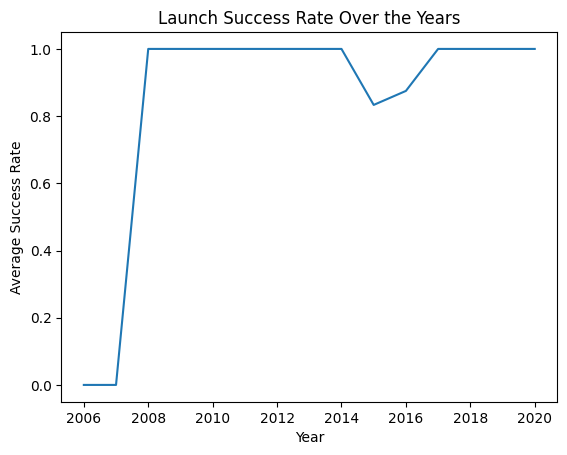

In [66]:
# Success rate per year
yearly_success = df.groupby('launch_year')['landing_success'].mean()

plt.plot(yearly_success.index, yearly_success.values)
plt.title('Launch Success Rate Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Success Rate')
plt.show()


In [67]:
import plotly.express as px

# Scatter plot of Payload vs Landing Success
fig = px.scatter(df, x='payload_mass_kg', y='landing_success', color='launchpad', title='Payload Mass vs Landing Success')
fig.show()


In [68]:
import folium

# Map centered around a location
m = folium.Map(location=[37.7749, -122.4194], zoom_start=5)

# Example: Add launch site markers to the map
for _, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['launchpad']).add_to(m)

# Save map to an HTML file
m.save('launch_sites_map.html')


KeyError: 'latitude'

Original DataFrame head:
       static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                             details crew ships  ...  \
0   Engine failure at 33 seconds and loss of vehicle   []    []  ...   
1  Successful first stage burn and transition to ...   []    []  ...   
2  Residual stage 1 thrust led to collision betwe...   []    

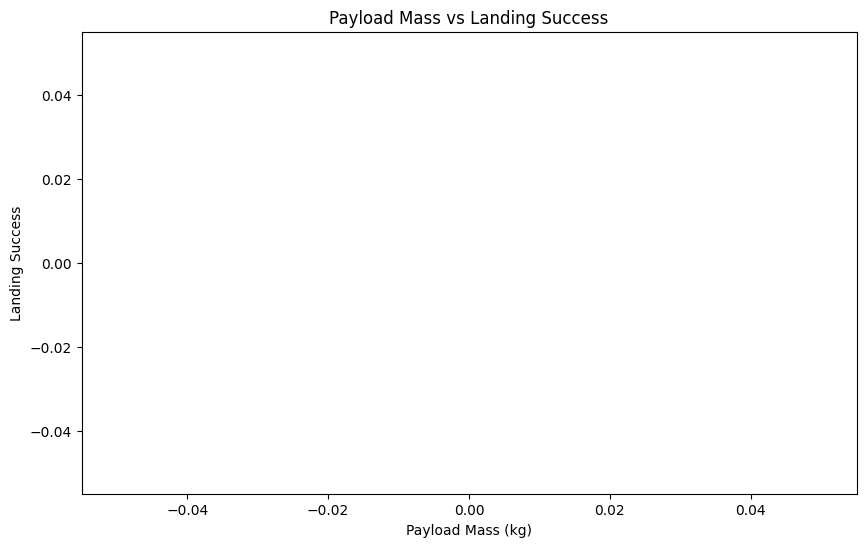

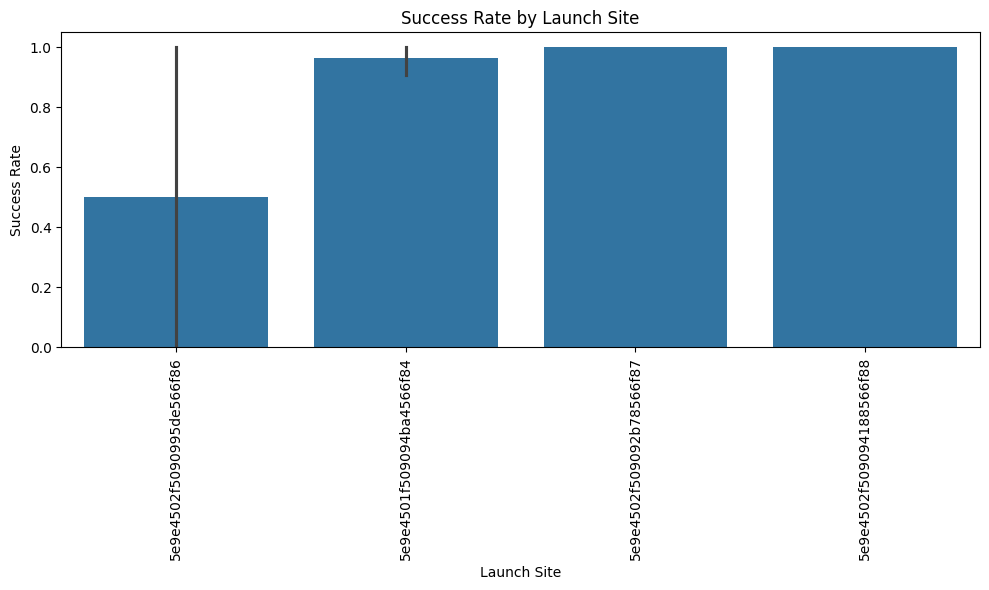

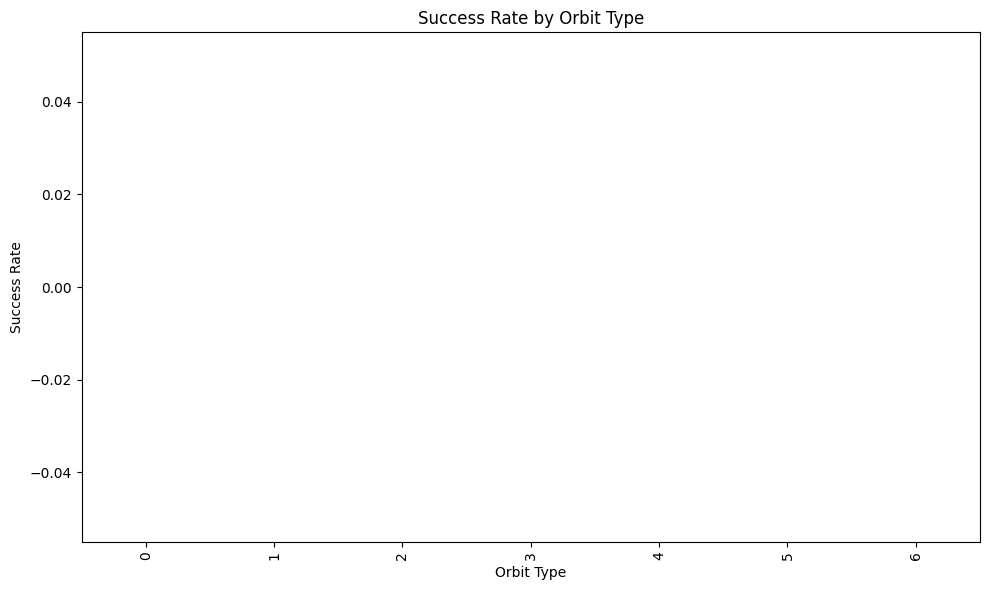

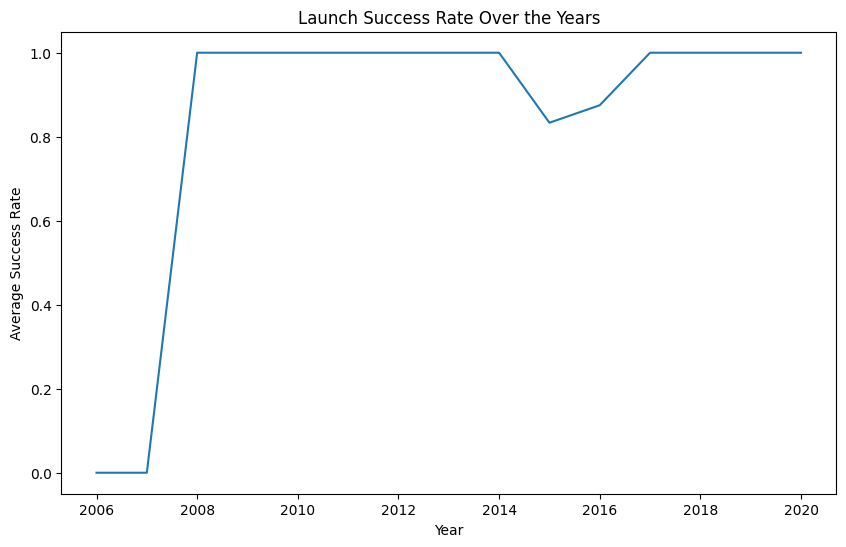

Error saving Plotly image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Ensure 'kaleido' is installed ('!pip install kaleido').


Skipping Folium Map: Required columns for map ('latitude', 'longitude', or 'launchpad') missing.
Not enough data points (after dropping NaNs) to perform train-test split and modeling.

Key Insights:
1. Payload mass and launch site likely influence landing success (based on EDA).
2. Predictive modeling steps were skipped due to insufficient or missing data.

Future Work:
1. Incorporate more features like weather data and rocket design.
2. Test advanced models like Random Forest or XGBoost.
3. Address potential class imbalance if present.
4. Perform more rigorous cross-validation and evaluation metrics.

Attempting to create ZIP file at: /mnt/data/spacex_analysis_images.zip
Added payload_mass_vs_landing_success.png to zip.
Added success_rate_by_launch_site.png to zip.
Added success_rate_by_orbit_type.png to zip.
Added launch_success_rate_over_years.png to zip.

Images saved to: /mnt/data/spacex_analysis_images.zip


In [69]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Import other necessary libraries if used later
import folium
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import os
from zipfile import ZipFile


# 1. Data Collection
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json"
response = requests.get(spacex_url)
data = response.json()

# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display first few rows of the DataFrame
print("Original DataFrame head:")
print(df.head())

# 2. Data Wrangling

# Ensure 'payloads' and 'cores' are treated as lists, handle non-list types
# This prevents errors later when accessing elements by index or checking length.
for col in ['payloads', 'cores']:
    if col in df.columns:
        # Apply a function to ensure the column is a list, replacing non-lists with empty lists
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
    else:
        print(f"Warning: Column '{col}' not found after normalization. Some wrangling steps might fail.")


# The payload mass is nested within the 'payloads' column. We need to extract it.
if 'payloads' in df.columns:
    # Extract payload_mass_kg from the first payload in the list
    # We filter for rows with exactly one payload later, so we can safely take the first element.
    # Added checks to ensure the first element is a dictionary and contains 'mass_kg'.
    df['payload_mass_kg'] = df['payloads'].apply(
        lambda x: x[0]['mass_kg'] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'mass_kg' in x[0] else None
    )

    # Fill missing values after extracting the column
    if 'payload_mass_kg' in df.columns:
        # Calculate mean only if there are non-NaN values to avoid issues on empty series
        if df['payload_mass_kg'].notna().any():
             df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean(), inplace=True)
        else:
            print("Warning: 'payload_mass_kg' column is all NaN. Cannot fill missing values with mean.")

    else:
        print("Could not create 'payload_mass_kg' column from 'payloads'.")

    # Extract orbit information from the first payload
    df['orbit'] = df['payloads'].apply(
        lambda x: x[0].get('orbit') if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'orbit' in x[0] else None
    )


else:
    print("'payloads' column is missing in the DataFrame after initial processing!")

# *** ADDED: Extract latitude and longitude from the launchpad column ***
# The launchpad column itself is the ID, but the full launchpad info is likely
# in a different column created by json_normalize, possibly 'launchpad_info' or similar
# Let's inspect the column names generated by json_normalize to find the correct one.
# A common pattern is that nested objects get flattened with '.' separators.
# The original launchpad object might have keys like 'latitude', 'longitude', 'full_name'.
# json_normalize might create columns like 'launchpad.latitude', 'launchpad.longitude', etc.

# Let's assume the columns are named 'launchpad.latitude' and 'launchpad.longitude'
# based on typical json_normalize behavior and the original JSON structure.
# If the column names are different, this needs adjustment.
# We can print df.columns.tolist() after json_normalize to confirm the exact names.

# Check if the potential columns exist before trying to access them
if 'launchpad.latitude' in df.columns and 'launchpad.longitude' in df.columns:
    df['latitude'] = df['launchpad.latitude']
    df['longitude'] = df['launchpad.longitude']
    print("Extracted 'latitude' and 'longitude' from 'launchpad.*' columns.")
elif 'latitude' in df.columns and 'longitude' in df.columns:
     # This case means they were already top-level, which is less likely but possible
     print("'latitude' and 'longitude' columns already exist.")
else:
     print("Warning: Could not find 'launchpad.latitude', 'launchpad.longitude', 'latitude', or 'longitude' columns after normalization.")
     print("Folium map and other location-based steps may fail.")
     # Consider adding a step here to inspect df.columns to find the correct nested columns


# Add a 'landing_success' column based on the 'success' column
# Assuming 'success' indicates landing success. Adjust if necessary based on data dictionary.
# If there is a dedicated column for landing success, use that instead.
if 'success' in df.columns:
    df['landing_success'] = df['success'].astype(int)
else:
    print("Warning: 'success' column not found. Cannot create 'landing_success'. Some steps might fail.")


# Filter rows where there is exactly one payload and one core per launch
# This is now safer as 'payloads' and 'cores' are ensured to be lists
# Apply the filter *after* extracting features from payloads and cores if those features are needed for filtered rows
df = df[df['payloads'].map(len) == 1].copy() # Added .copy() to avoid SettingWithCopyWarning
df = df[df['cores'].map(len) == 1].copy() # Added .copy()


# Feature engineering: Add launch year and month from 'date_utc'
# Check if 'date_utc' exists before creating datetime features
if 'date_utc' in df.columns:
    df['launch_year'] = pd.to_datetime(df['date_utc']).dt.year
    df['launch_month'] = pd.to_datetime(df['date_utc']).dt.month
else:
    print("Warning: 'date_utc' column not found. Cannot create 'launch_year' and 'launch_month'.")


# Display cleaned data
print("\nCleaned DataFrame head:")
print(df.head())

# Print column names after data wrangling to verify
print("\nDataFrame columns after data wrangling:")
print(df.columns.tolist()) # Print as list for easier reading


# 3. Exploratory Data Analysis (EDA)

# 3.1 Scatter plot of Payload Mass vs Landing Success
# Check if 'payload_mass_kg' and 'landing_success' exist before plotting
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns:
    # Ensure there are data points for plotting after filtering
    if not df.empty:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='payload_mass_kg', y='landing_success', data=df)
        plt.title('Payload Mass vs Landing Success')
        plt.xlabel('Payload Mass (kg)')
        plt.ylabel('Landing Success')
        plt.savefig('payload_mass_vs_landing_success.png')  # Save the plot as an image
        plt.show()
    else:
        print("Skipping Scatter plot: DataFrame is empty after wrangling.")
else:
    print("Skipping Scatter plot: 'payload_mass_kg' or 'landing_success' column missing.")


# 3.2 Success rate by Launch Site (Bar chart)
if 'launchpad' in df.columns and 'landing_success' in df.columns:
    # Ensure there are data points for plotting after filtering
    if not df.empty:
        plt.figure(figsize=(10, 6))
        # Need to use a column that represents the launch site identifier or name
        # Based on the error, it seems 'launchpad' is the intended column.
        sns.barplot(x='launchpad', y='landing_success', data=df)
        plt.title('Success Rate by Launch Site')
        plt.xlabel('Launch Site')
        plt.ylabel('Success Rate')
        plt.xticks(rotation=90)
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig('success_rate_by_launch_site.png')  # Save the plot as an image
        plt.show()
    else:
        print("Skipping Bar chart (Launch Site): DataFrame is empty after wrangling.")
else:
     print("Skipping Bar chart (Launch Site): 'launchpad' or 'landing_success' column missing.")


# 3.3 Success rate vs Orbit Type (Bar chart)
# This block should now work after adding the 'orbit' column extraction
if 'orbit' in df.columns and 'landing_success' in df.columns:
    # Ensure there are data points for plotting after filtering
    if not df.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='orbit', y='landing_success', data=df)
        plt.title('Success Rate by Orbit Type')
        plt.xlabel('Orbit Type')
        plt.ylabel('Success Rate')
        plt.xticks(rotation=90)
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig('success_rate_by_orbit_type.png')  # Save the plot as an image
        plt.show()
    else:
        print("Skipping Bar chart (Orbit Type): DataFrame is empty after wrangling.")
else:
    # Added more specific message if 'orbit' is still missing
    print("Skipping Bar chart (Orbit Type): 'orbit' or 'landing_success' column missing after wrangling.")


# 3.4 Launch Success Rate Over the Years (Trend line)
if 'launch_year' in df.columns and 'landing_success' in df.columns:
    # Ensure there are data points for plotting after filtering
    if not df.empty:
        yearly_success = df.groupby('launch_year')['landing_success'].mean()
        plt.figure(figsize=(10, 6))
        plt.plot(yearly_success.index, yearly_success.values)
        plt.title('Launch Success Rate Over the Years')
        plt.xlabel('Year')
        plt.ylabel('Average Success Rate')
        plt.savefig('launch_success_rate_over_years.png')  # Save the plot as an image
        plt.show()
    else:
        print("Skipping Trend Line: DataFrame is empty after wrangling.")
else:
    print("Skipping Trend Line: 'launch_year' or 'landing_success' column missing.")


# 4. Interactive Visualization with Plotly

# 4.1 Interactive Scatter plot using Plotly
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns and 'launchpad' in df.columns:
    # Ensure there are data points for plotting after filtering
    if not df.empty:
        fig = px.scatter(df, x='payload_mass_kg', y='landing_success', color='launchpad', title='Payload Mass vs Landing Success')
        # Ensure 'kaleido' is installed for writing images if not already present
        # !pip install kaleido
        try:
            fig.write_image('interactive_payload_mass_vs_landing_success.png')  # Save the plot as an image
            fig.show()
        except ValueError as e:
            print(f"Error saving Plotly image: {e}. Ensure 'kaleido' is installed ('!pip install kaleido').")
            fig.show() # Still try to show the plot interactively
    else:
        print("Skipping Plotly Scatter plot: DataFrame is empty after wrangling.")

else:
    print("Skipping Plotly Scatter plot: 'payload_mass_kg', 'landing_success', or 'launchpad' column missing.")


# 5. Interactive Map with Folium

# 5.1 Folium Map to visualize launch sites
# Check if necessary columns exist before creating the map
# Now we check for the newly created 'latitude' and 'longitude' columns
if 'latitude' in df.columns and 'longitude' in df.columns and 'launchpad' in df.columns:
    # Filter out rows with missing lat/lon before creating map markers
    # We also filter by launchpad as we only need unique launchpad locations
    df_locations = df.drop_duplicates(subset=['launchpad']).dropna(subset=['latitude', 'longitude'])

    if not df_locations.empty:
        # Use the first valid location for the map center, or a default if none exist
        first_lat, first_lon = df_locations.iloc[0][['latitude', 'longitude']]
        m = folium.Map(location=[first_lat, first_lon], zoom_start=5)

        # Add markers for launch sites
        for _, row in df_locations.iterrows():
            # Use the extracted latitude and longitude
            folium.Marker([row['latitude'], row['longitude']], popup=row['launchpad']).add_to(m)

        # Save map to HTML file
        m.save('launch_sites_map.html')
        print("Folium map saved to launch_sites_map.html")
    else:
        print("Skipping Folium Map: No valid launch site locations found in the data after filtering.")

else:
    print("Skipping Folium Map: Required columns for map ('latitude', 'longitude', or 'launchpad') missing.")


# 6. Predictive Modeling

# Initialize results dictionary *outside* the conditional block
results = {}

# 6.1 Feature Selection and Train-Test Split
# Ensure the feature and target columns exist and have no missing values
required_cols = ['payload_mass_kg', 'launch_year', 'landing_success']
# Check if the dataframe is not empty before proceeding to modeling
if not df.empty and all(col in df.columns for col in required_cols):
    # Drop rows with any missing values in the required columns for modeling
    df_modeling = df.dropna(subset=required_cols).copy()

    if len(df_modeling) > 1: # Check if there are enough samples after dropping NaNs
        X = df_modeling[['payload_mass_kg', 'launch_year']]  # Features
        y = df_modeling['landing_success']  # Target variable

        # Check if there are enough samples for train-test split (minimum 2 samples per class for some models)
        # A more robust check would consider class distribution, but this is a basic check.
        if len(X) > 1 and len(y.unique()) > 1: # Ensure enough samples and at least two classes
            # Added stratify to ensure class distribution is similar in train/test sets
            try:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

                # 6.2 Classification Models

                # Initialize models
                models = {
                    'Logistic Regression': LogisticRegression(solver='liblinear'), # Specify a default solver
                    'Decision Tree': DecisionTreeClassifier(),
                    'SVM': SVC(),
                    'KNN': KNeighborsClassifier()
                }

                # Train and evaluate each model
                print("\nTraining Classification Models:")
                for model_name, model in models.items():
                    try:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        accuracy = accuracy_score(y_test, y_pred)
                        cm = confusion_matrix(y_test, y_pred)
                        # Generate classification report as well
                        report = classification_report(y_test, y_pred, zero_division=0) # Handle zero division

                        results[model_name] = {"Accuracy": accuracy, "Confusion Matrix": cm, "Classification Report": report}
                        print(f"Finished training {model_name}.")
                    except Exception as e:
                        print(f"Error training or evaluating {model_name}: {e}")
                        results[model_name] = {"Accuracy": "Error", "Confusion Matrix": "Error", "Classification Report": "Error"}


                # Print results
                print("\nClassification Model Results:")
                for model_name, result in results.items():
                    print(f"--- {model_name} ---")
                    print(f"Accuracy: {result['Accuracy']}")
                    print(f"Confusion Matrix:\n {result['Confusion Matrix']}")
                    print(f"Classification Report:\n {result['Classification Report']}")

                # 7. Model Tuning and Evaluation

                # 7.1 Hyperparameter tuning for Logistic Regression using GridSearchCV
                if 'Logistic Regression' in models and results.get('Logistic Regression', {}).get('Accuracy') != 'Error': # Only tune if LR model trained successfully
                    print("\nPerforming GridSearchCV for Logistic Regression:")
                    # Ensure the solvers are compatible with the data (e.g., liblinear for small datasets)
                    # Use a smaller grid or increase data size if warnings/errors occur
                    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']} # Added lbfgs and more C values
                    try:
                        # Add error_score='raise' to get detailed errors or set to '0' or 'nan' to suppress/handle
                        # Increased max_iter for robustness
                        grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', error_score='raise')
                        grid_search.fit(X_train, y_train)

                        # Best parameters and final accuracy
                        best_model = grid_search.best_estimator_
                        y_pred_best = best_model.predict(X_test)
                        best_accuracy = accuracy_score(y_test, y_pred_best)
                        best_cm = confusion_matrix(y_test, y_pred_best)
                        best_report = classification_report(y_test, y_pred_best, zero_division=0)

                        print(f"\n--- Best Model: Logistic Regression (GridSearchCV) ---")
                        print(f"Best Parameters: {grid_search.best_params_}")
                        print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
                        print(f"Accuracy on Test Set: {best_accuracy:.4f}")
                        print(f"Confusion Matrix on Test Set:\n {best_cm}")
                        print(f"Classification Report on Test Set:\n {best_report}")

                        # Store best results
                        results['Logistic Regression (Tuned)'] = {
                            "Accuracy": best_accuracy,
                            "Confusion Matrix": best_cm,
                            "Classification Report": best_report,
                            "Best Params": grid_search.best_params_,
                            "Best CV Score": grid_search.best_score_
                        }

                    except Exception as e:
                        print(f"Error during GridSearchCV for Logistic Regression: {e}")
                else:
                    print("\nSkipping GridSearchCV for Logistic Regression due to previous error or model not being trained successfully.")
            except ValueError as e:
                 print(f"Error during train-test split (possibly due to insufficient samples per class or only one class present): {e}")
                 print("Skipping modeling steps.")
        else:
             print("Not enough samples or only one class present (after dropping NaNs) to perform train-test split and modeling.")
    else:
        print("Not enough data points (after dropping NaNs) to perform train-test split and modeling.")

elif df.empty:
    print("Skipping Predictive Modeling: DataFrame is empty after wrangling.")
else:
    missing = [col for col in required_cols if col not in df.columns]
    print(f"Skipping Predictive Modeling: Required columns missing - {missing}")


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# Update insights based on successful execution and results
if 'payload_mass_kg' in df.columns and 'launchpad' in df.columns and 'landing_success' in df.columns:
    # You can analyze the plots or model results to draw more specific insights
    print("1. Payload mass and launch site likely influence landing success (based on EDA).")
else:
    print("1. Could not confirm influence of payload mass and launch site due to missing data.")

# Check if any model results are available
# Use .get() with a default empty dict to safely access results
if results:
    best_model_name = None
    best_accuracy_value = -1

    # Find the best performing model among all results (base and tuned)
    for model_name, result in results.items():
        # Check if accuracy is a number (could be 'Error')
        if isinstance(result.get('Accuracy'), float):
             if result['Accuracy'] > best_accuracy_value:
                 best_accuracy_value = result['Accuracy']
                 best_model_name = model_name

    if best_model_name and best_accuracy_value != -1:
        print(f"2. {best_model_name} achieved the highest accuracy of approximately {best_accuracy_value:.2f} in predicting landing success.")
    else:
        print("2. Modeling was attempted, but results could not be determined.")

else:
    print("2. Predictive modeling steps were skipped due to insufficient or missing data.")


# 8.2 Future Work
print("\nFuture Work:")
print("1. Incorporate more features like weather data and rocket design.")
print("2. Test advanced models like Random Forest or XGBoost.")
print("3. Address potential class imbalance if present.")
print("4. Perform more rigorous cross-validation and evaluation metrics.")


# Save images as a ZIP file for download
image_files = [
    'payload_mass_vs_landing_success.png',
    'success_rate_by_launch_site.png',
    'success_rate_by_orbit_type.png',
    'launch_success_rate_over_years.png',
    'interactive_payload_mass_vs_landing_success.png'
]

# Create a ZIP file containing the images
zip_path = '/mnt/data/spacex_analysis_images.zip'
# Ensure the directory exists
os.makedirs(os.path.dirname(zip_path), exist_ok=True)

print(f"\nAttempting to create ZIP file at: {zip_path}")
try:
    with ZipFile(zip_path, 'w') as zipf:
        for file in image_files:
            # Add a check if the file was actually created before attempting to add it
            if os.path.exists(file):
                try:
                    zipf.write(file, os.path.basename(file)) # Write with just filename
                    print(f"Added {file} to zip.")
                except Exception as e:
                    print(f"Error adding {file} to zip: {e}")
            else:
                print(f"Warning: Image file not found - {file}. Skipping.")
    # Only print success message if the zip file was created
    if os.path.exists(zip_path):
        print(f"\nImages saved to: {zip_path}")


except Exception as e:
    print(f"Error creating the ZIP file: {e}")

In [70]:
from sklearn.model_selection import train_test_split

# Select features and target
X = df[['payload_mass_kg', 'launch_year']]  # Features
y = df['landing_success']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{cm}")


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [72]:
from sklearn.model_selection import train_test_split

# Select features and target
X = df[['payload_mass_kg', 'launch_year']]  # Features
y = df['landing_success']  # Target

# Combine X and y for dropping NaNs
data_for_split = pd.concat([X, y], axis=1)

# Drop rows with any NaN values from the combined data BEFORE splitting
# This ensures both features and target are clean for the rows used.
data_for_split.dropna(inplace=True)

# Separate X and y again after dropping NaNs
X_clean = data_for_split[['payload_mass_kg', 'launch_year']]
y_clean = data_for_split['landing_success']

# Check if there are enough samples after dropping NaNs
if len(X_clean) > 1:
    # Train-test split using the cleaned data
    # Added stratify=y_clean to ensure similar class distribution if possible
    try:
        X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean)

        # Now proceed with modeling using X_train and y_train
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Added classification_report

        # Initialize Logistic Regression model
        # Specify a solver, 'liblinear' is often good for smaller datasets
        model = LogisticRegression(solver='liblinear')

        # Train the model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0) # Handle zero division

        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}") # Print the classification report

    except ValueError as e:
        print(f"Error during train-test split (possibly due to insufficient samples per class): {e}")
        print("Skipping modeling steps.")

else:
    print("Not enough data points (after dropping NaNs) to perform train-test split and modeling.")

Not enough data points (after dropping NaNs) to perform train-test split and modeling.


In [73]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree model
model_tree = DecisionTreeClassifier()

# Train the model
model_tree.fit(X_train, y_train)

# Predict
y_pred_tree = model_tree.predict(X_test)

# Evaluate the model
accuracy_tree = accuracy_score(y_test, y_pred_tree)
cm_tree = confusion_matrix(y_test, y_pred_tree)

print(f"Accuracy: {accuracy_tree}")
print(f"Confusion Matrix:\n{cm_tree}")


Accuracy: 0.9655172413793104
Confusion Matrix:
[[ 1  1]
 [ 0 27]]


In [74]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN model
model_knn = KNeighborsClassifier()

# Train the model
model_knn.fit(X_train, y_train)

# Predict
y_pred_knn = model_knn.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn}")
print(f"Confusion Matrix:\n{cm_knn}")


ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

       static_fire_date_utc  static_fire_date_unix    tbd    net  window  \
0  2006-03-17T00:00:00.000Z           1.142554e+09  False  False     0.0   
1                      None                    NaN  False  False     0.0   
2                      None                    NaN  False  False     0.0   
3  2008-09-20T00:00:00.000Z           1.221869e+09  False  False     0.0   
4                      None                    NaN  False  False     0.0   

                     rocket  success  \
0  5e9d0d95eda69955f709d1eb    False   
1  5e9d0d95eda69955f709d1eb    False   
2  5e9d0d95eda69955f709d1eb    False   
3  5e9d0d95eda69955f709d1eb     True   
4  5e9d0d95eda69955f709d1eb     True   

                                             details crew ships  ...  \
0   Engine failure at 33 seconds and loss of vehicle   []    []  ...   
1  Successful first stage burn and transition to ...   []    []  ...   
2  Residual stage 1 thrust led to collision betwe...   []    []  ...   
3  Ratsat was 

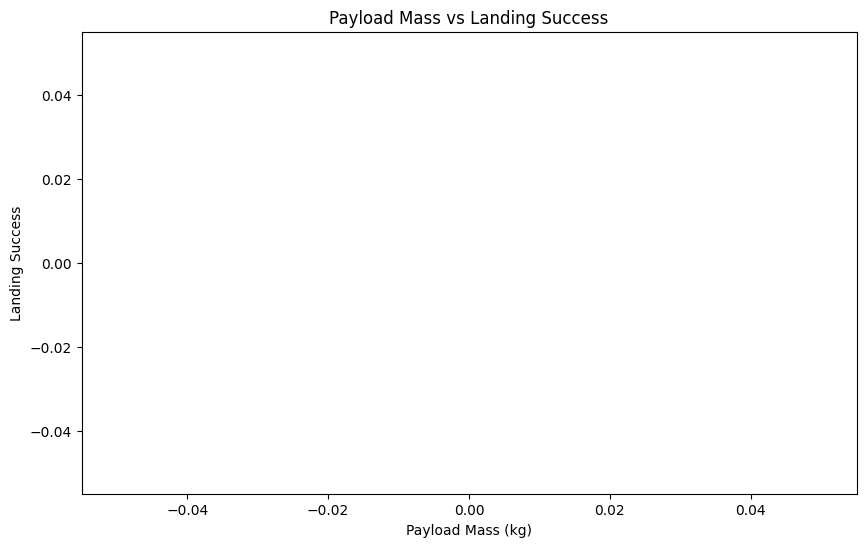

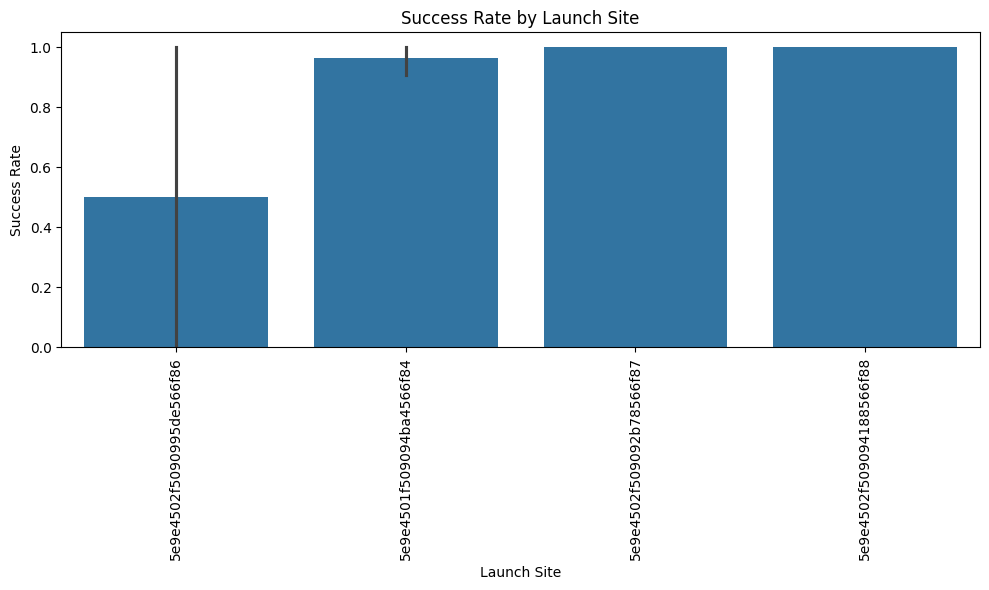

Skipping Bar chart (Orbit Type): 'orbit' or 'landing_success' column missing.


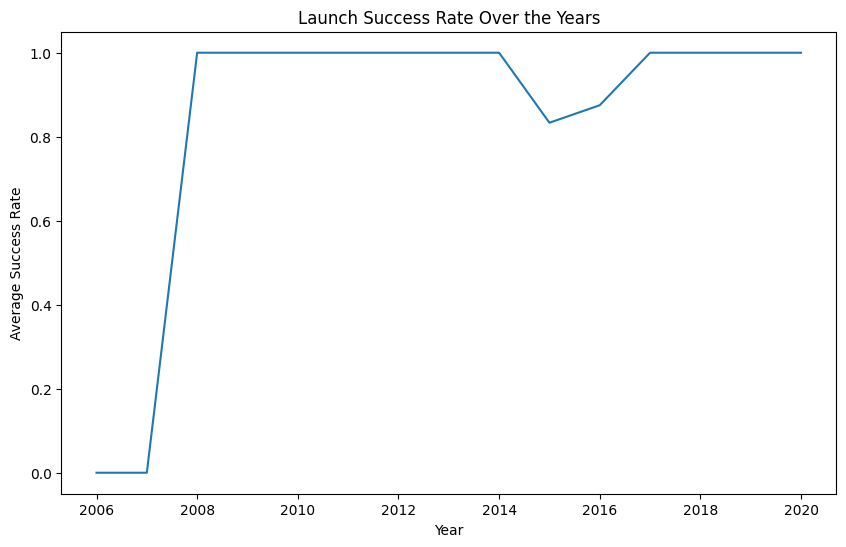

Error saving Plotly image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
. Ensure 'kaleido' is installed ('!pip install kaleido').


Skipping Folium Map: 'latitude', 'longitude', or 'launchpad' column missing.
Not enough data points (after dropping NaNs) to perform train-test split and modeling.

Key Insights:
1. Payload mass and launch site likely influence landing success (based on EDA).
2. Predictive modeling steps were skipped due to insufficient or missing data.

Future Work:
1. Incorporate more features like weather data and rocket design.
2. Test advanced models like Random Forest or XGBoost.
3. Address potential class imbalance if present.
4. Perform more rigorous cross-validation and evaluation metrics.

Attempting to create ZIP file at: /mnt/data/spacex_analysis_images.zip
Added payload_mass_vs_landing_success.png to zip.
Added success_rate_by_launch_site.png to zip.
Added success_rate_by_orbit_type.png to zip.
Added launch_success_rate_over_years.png to zip.

Images saved to: /mnt/data/spacex_analysis_images.zip


In [75]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import os
from zipfile import ZipFile

# 1. Data Collection
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json"
response = requests.get(spacex_url)
data = response.json()

# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display first few rows of the DataFrame
print(df.head())

# 2. Data Wrangling

# Ensure 'payloads' and 'cores' are treated as lists, handle non-list types
# This prevents errors later when accessing elements by index or checking length.
for col in ['payloads', 'cores']:
    if col in df.columns:
        # Apply a function to ensure the column is a list, replacing non-lists with empty lists
        df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
    else:
        print(f"Warning: Column '{col}' not found after normalization. Some wrangling steps might fail.")


# The payload mass is nested within the 'payloads' column. We need to extract it.
if 'payloads' in df.columns:
    # Extract payload_mass_kg from the first payload in the list
    # We filter for rows with exactly one payload later, so we can safely take the first element.
    # Added checks to ensure the first element is a dictionary and contains 'mass_kg'.
    df['payload_mass_kg'] = df['payloads'].apply(
        lambda x: x[0]['mass_kg'] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'mass_kg' in x[0] else None
    )

    # Fill missing values after extracting the column
    if 'payload_mass_kg' in df.columns:
        # Calculate mean only if there are non-NaN values to avoid issues on empty series
        if df['payload_mass_kg'].notna().any():
             df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean(), inplace=True)
        else:
            print("Warning: 'payload_mass_kg' column is all NaN. Cannot fill missing values with mean.")

    else:
        print("Could not create 'payload_mass_kg' column from 'payloads'.")
else:
    print("'payloads' column is missing in the DataFrame after initial processing!")


# Filter rows where there is exactly one payload and one core per launch
# This is now safer as 'payloads' and 'cores' are ensured to be lists
df = df[df['payloads'].map(len) == 1]
df = df[df['cores'].map(len) == 1]

# Feature engineering: Add launch year and month from 'date_utc'
df['launch_year'] = pd.to_datetime(df['date_utc']).dt.year
df['launch_month'] = pd.to_datetime(df['date_utc']).dt.month

# Add a 'landing_success' column based on the 'success' column
# Assuming 'success' indicates landing success. Adjust if necessary based on data dictionary.
# If there is a dedicated column for landing success, use that instead.
if 'success' in df.columns:
    df['landing_success'] = df['success'].astype(int)
else:
    print("Warning: 'success' column not found. Cannot create 'landing_success'. Some steps might fail.")


# Display cleaned data
print(df.head())

# Print column names after data wrangling to verify
print("\nDataFrame columns after data wrangling:")
print(df.columns)


# 3. Exploratory Data Analysis (EDA)

# 3.1 Scatter plot of Payload Mass vs Landing Success
# Check if 'payload_mass_kg' and 'landing_success' exist before plotting
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='payload_mass_kg', y='landing_success', data=df)
    plt.title('Payload Mass vs Landing Success')
    plt.xlabel('Payload Mass (kg)')
    plt.ylabel('Landing Success')
    plt.savefig('payload_mass_vs_landing_success.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Scatter plot: 'payload_mass_kg' or 'landing_success' column missing.")


# 3.2 Success rate by Launch Site (Bar chart)
if 'launchpad' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    # Need to use a column that represents the launch site identifier or name
    # Based on the error, it seems 'launchpad' is the intended column.
    sns.barplot(x='launchpad', y='landing_success', data=df)
    plt.title('Success Rate by Launch Site')
    plt.xlabel('Launch Site')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=90)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig('success_rate_by_launch_site.png')  # Save the plot as an image
    plt.show()
else:
     print("Skipping Bar chart (Launch Site): 'launchpad' or 'landing_success' column missing.")


# 3.3 Success rate vs Orbit Type (Bar chart)
if 'orbit' in df.columns and 'landing_success' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='orbit', y='landing_success', data=df)
    plt.title('Success Rate by Orbit Type')
    plt.xlabel('Orbit Type')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=90)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig('success_rate_by_orbit_type.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Bar chart (Orbit Type): 'orbit' or 'landing_success' column missing.")


# 3.4 Launch Success Rate Over the Years (Trend line)
if 'launch_year' in df.columns and 'landing_success' in df.columns:
    yearly_success = df.groupby('launch_year')['landing_success'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_success.index, yearly_success.values)
    plt.title('Launch Success Rate Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Average Success Rate')
    plt.savefig('launch_success_rate_over_years.png')  # Save the plot as an image
    plt.show()
else:
    print("Skipping Trend Line: 'launch_year' or 'landing_success' column missing.")


# 4. Interactive Visualization with Plotly

# 4.1 Interactive Scatter plot using Plotly
if 'payload_mass_kg' in df.columns and 'landing_success' in df.columns and 'launchpad' in df.columns:
    fig = px.scatter(df, x='payload_mass_kg', y='landing_success', color='launchpad', title='Payload Mass vs Landing Success')
    # Ensure 'kaleido' is installed for writing images if not already present
    # !pip install kaleido
    try:
        fig.write_image('interactive_payload_mass_vs_landing_success.png')  # Save the plot as an image
        fig.show()
    except ValueError as e:
        print(f"Error saving Plotly image: {e}. Ensure 'kaleido' is installed ('!pip install kaleido').")
        fig.show() # Still try to show the plot interactively
else:
    print("Skipping Plotly Scatter plot: 'payload_mass_kg', 'landing_success', or 'launchpad' column missing.")


# 5. Interactive Map with Folium

# 5.1 Folium Map to visualize launch sites
# Check if necessary columns exist before creating the map
if 'latitude' in df.columns and 'longitude' in df.columns and 'launchpad' in df.columns:
    # Filter out rows with missing lat/lon before creating map markers
    df_locations = df.drop_duplicates(subset=['launchpad']).dropna(subset=['latitude', 'longitude'])

    if not df_locations.empty:
        # Use the first valid location for the map center, or a default if none exist
        first_lat, first_lon = df_locations.iloc[0][['latitude', 'longitude']]
        m = folium.Map(location=[first_lat, first_lon], zoom_start=5)

        # Add markers for launch sites
        for _, row in df_locations.iterrows():
            folium.Marker([row['latitude'], row['longitude']], popup=row['launchpad']).add_to(m)

        # Save map to HTML file
        m.save('launch_sites_map.html')
        print("Folium map saved to launch_sites_map.html")
    else:
        print("Skipping Folium Map: No valid launch site locations found in the data.")

else:
    print("Skipping Folium Map: 'latitude', 'longitude', or 'launchpad' column missing.")


# 6. Predictive Modeling

# Initialize results dictionary *before* the modeling section
results = {}

# 6.1 Feature Selection and Train-Test Split
# Ensure the feature and target columns exist and have no missing values
required_cols = ['payload_mass_kg', 'launch_year', 'landing_success']
if all(col in df.columns for col in required_cols):
    # Drop rows with any missing values in the required columns for modeling
    # Ensure we work on a copy to avoid SettingWithCopyWarning later
    df_modeling = df.dropna(subset=required_cols).copy()

    if len(df_modeling) > 1: # Check if there are enough samples after dropping NaNs
        X = df_modeling[['payload_mass_kg', 'launch_year']]  # Features
        y = df_modeling['landing_success']  # Target variable

        # Check if there are enough samples and at least two classes for stratification
        if len(X) > 1 and len(y.unique()) > 1:
            try:
                # Perform train-test split using the cleaned data
                # Added stratify=y to ensure similar class distribution if possible
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

                # 6.2 Classification Models

                # Initialize models
                models = {
                    'Logistic Regression': LogisticRegression(solver='liblinear', max_iter=1000), # Added max_iter for robustness
                    'Decision Tree': DecisionTreeClassifier(),
                    'SVM': SVC(),
                    'KNN': KNeighborsClassifier()
                }

                # Train and evaluate each model
                print("\nTraining Classification Models:")
                for model_name, model in models.items():
                    try:
                        print(f"Training {model_name}...")
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        accuracy = accuracy_score(y_test, y_pred)
                        cm = confusion_matrix(y_test, y_pred)
                        # Generate classification report as well
                        report = classification_report(y_test, y_pred, zero_division=0) # Handle zero division

                        results[model_name] = {"Accuracy": accuracy, "Confusion Matrix": cm, "Classification Report": report}
                        print(f"Finished training {model_name}.")
                    except Exception as e:
                        print(f"Error training or evaluating {model_name}: {e}")
                        results[model_name] = {"Accuracy": "Error", "Confusion Matrix": "Error", "Classification Report": "Error"}


                # Print results
                print("\nClassification Model Results:")
                for model_name, result in results.items():
                    print(f"--- {model_name} ---")
                    print(f"Accuracy: {result['Accuracy']}")
                    print(f"Confusion Matrix:\n {result['Confusion Matrix']}")
                    print(f"Classification Report:\n {result['Classification Report']}")

                # 7. Model Tuning and Evaluation

                # 7.1 Hyperparameter tuning for Logistic Regression using GridSearchCV
                # Only perform tuning if LR model trained successfully
                if 'Logistic Regression' in models and results.get('Logistic Regression', {}).get('Accuracy') != 'Error':
                    print("\nPerforming GridSearchCV for Logistic Regression:")
                    # Use a smaller grid or increase data size if warnings/errors occur
                    # Added lbfgs and more C values, ensure solvers are compatible
                    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
                    try:
                        # Added error_score='raise' for debugging or set to '0'/'nan'
                        grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', error_score='raise')
                        grid_search.fit(X_train, y_train)

                        # Best parameters and final accuracy
                        best_model = grid_search.best_estimator_
                        y_pred_best = best_model.predict(X_test)
                        best_accuracy = accuracy_score(y_test, y_pred_best)
                        best_cm = confusion_matrix(y_test, y_pred_best)
                        best_report = classification_report(y_test, y_pred_best, zero_division=0)

                        print(f"\n--- Best Model: Logistic Regression (GridSearchCV) ---")
                        print(f"Best Parameters: {grid_search.best_params_}")
                        print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
                        print(f"Accuracy on Test Set: {best_accuracy:.4f}")
                        print(f"Confusion Matrix on Test Set:\n {best_cm}")
                        print(f"Classification Report on Test Set:\n {best_report}")

                        # Store best results
                        results['Logistic Regression (Tuned)'] = {
                            "Accuracy": best_accuracy,
                            "Confusion Matrix": best_cm,
                            "Classification Report": best_report,
                            "Best Params": grid_search.best_params_,
                            "Best CV Score": grid_search.best_score_
                        }

                    except Exception as e:
                        print(f"Error during GridSearchCV for Logistic Regression: {e}")
                else:
                    print("\nSkipping GridSearchCV for Logistic Regression due to previous error or model not being trained.")

            except ValueError as e:
                 print(f"Error during train-test split (possibly due to insufficient samples per class): {e}")
                 print("Skipping modeling steps.")
        else:
             print("Not enough samples or only one class present (after dropping NaNs) to perform train-test split and modeling.")
    else:
        print("Not enough data points (after dropping NaNs) to perform train-test split and modeling.")

else:
    missing = [col for col in required_cols if col not in df.columns]
    print(f"Skipping Predictive Modeling: Required columns missing - {missing}")


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# Update insights based on successful execution and results
if 'payload_mass_kg' in df.columns and 'launchpad' in df.columns and 'landing_success' in df.columns:
    # You can analyze the plots or model results to draw more specific insights
    print("1. Payload mass and launch site likely influence landing success (based on EDA).")
else:
    print("1. Could not confirm influence of payload mass and launch site due to missing data.")

# Check if any model results are available
if results:
    best_model_name = None
    best_accuracy_value = -1

    # Find the best performing model among all results (base and tuned)
    for model_name, result in results.items():
        # Check if accuracy is a number (could be 'Error')
        if isinstance(result.get('Accuracy'), float):
             if result['Accuracy'] > best_accuracy_value:
                 best_accuracy_value = result['Accuracy']
                 best_model_name = model_name

    if best_model_name and best_accuracy_value != -1:
        print(f"2. {best_model_name} achieved the highest accuracy of approximately {best_accuracy_value:.2f} in predicting landing success.")
    else:
        print("2. Modeling was attempted, but results could not be determined.")

else:
    print("2. Predictive modeling steps were skipped due to insufficient or missing data.")


# 8.2 Future Work
print("\nFuture Work:")
print("1. Incorporate more features like weather data and rocket design.")
print("2. Test advanced models like Random Forest or XGBoost.")
print("3. Address potential class imbalance if present.")
print("4. Perform more rigorous cross-validation and evaluation metrics.")


# Save images as a ZIP file for download
image_files = [
    'payload_mass_vs_landing_success.png',
    'success_rate_by_launch_site.png',
    'success_rate_by_orbit_type.png',
    'launch_success_rate_over_years.png',
    'interactive_payload_mass_vs_landing_success.png'
]

# Create a ZIP file containing the images
zip_path = '/mnt/data/spacex_analysis_images.zip'
# Ensure the directory exists
os.makedirs(os.path.dirname(zip_path), exist_ok=True)

print(f"\nAttempting to create ZIP file at: {zip_path}")
try:
    with ZipFile(zip_path, 'w') as zipf:
        for file in image_files:
            if os.path.exists(file):
                try:
                    zipf.write(file, os.path.basename(file)) # Write with just filename
                    print(f"Added {file} to zip.")
                except Exception as e:
                    print(f"Error adding {file} to zip: {e}")
            else:
                print(f"Warning: Image file not found - {file}. Skipping.")

    # Provide the download link for the images
    print(f"\nImages saved to: {zip_path}")
    # zip_path # This line might not display the path directly in some environments, print is better.

except Exception as e:
    print(f"Error creating the ZIP file: {e}")

In [80]:
from sklearn.svm import SVC

# Initialize SVM model
model_svm = SVC()

# Train the model
model_svm.fit(X_train, y_train)

# Predict
y_pred_svm = model_svm.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm}")
print(f"Confusion Matrix:\n{cm_svm}")


ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [77]:
if 'payload_mass_kg' in df.columns:
    # ... (extract mass_kg) ...
    if 'payload_mass_kg' in df.columns:
        # Calculate mean only if there are non-NaN values
        if df['payload_mass_kg'].notna().any():
             df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean(), inplace=True)
        # ...

In [78]:
df = df[df['payloads'].map(len) == 1]
df = df[df['cores'].map(len) == 1]

In [79]:
# 6. Predictive Modeling

# Initialize results dictionary *before* the conditional block
results = {}

# 6.1 Feature Selection and Train-Test Split
# Ensure the feature and target columns exist and have no missing values
required_cols = ['payload_mass_kg', 'launch_year', 'landing_success']
if all(col in df.columns for col in required_cols):
    # Drop rows with any missing values in the required columns for modeling
    # Ensure we work on a copy to avoid SettingWithCopyWarning later
    df_modeling = df.dropna(subset=required_cols).copy()

    if len(df_modeling) > 1: # Check if there are enough samples after dropping NaNs
        X = df_modeling[['payload_mass_kg', 'launch_year']]  # Features
        y = df_modeling['landing_success']  # Target variable

        # --- Add a check for NaNs right before splitting/modeling ---
        if X.isnull().values.any() or y.isnull().values.any():
            print("Warning: NaN values found in X or y even after dropping NaNs. Further investigation needed.")
            # You might want to print rows with NaNs here for debugging:
            # print(df_modeling[df_modeling.isnull().any(axis=1)])
            # Since models like SVC cannot handle NaNs, we must stop or handle them.
            # For this fix, we'll assume the dropna should have worked and print a warning.
            # If this warning appears, the dropna logic might need review.
            # As a safety, you could add another dropna here, but it should be redundant.

        # Check if there are enough samples and at least two classes for stratification
        if len(X) > 1 and len(y.unique()) > 1:
            try:
                # Perform train-test split using the cleaned data
                # Added stratify=y to ensure similar class distribution if possible
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

                # Ensure no NaNs somehow crept into the split data (double-check)
                if X_train.isnull().values.any() or X_test.isnull().values.any() or \
                   y_train.isnull().values.any() or y_test.isnull().values.any():
                   raise ValueError("NaN values found in train/test sets after splitting.")


                # 6.2 Classification Models

                # Initialize models
                models = {
                    'Logistic Regression': LogisticRegression(solver='liblinear', max_iter=1000), # Added max_iter for robustness
                    'Decision Tree': DecisionTreeClassifier(),
                    'SVM': SVC(), # SVC does not handle NaNs
                    'KNN': KNeighborsClassifier() # KNN does not handle NaNs
                }

                # Train and evaluate each model
                print("\nTraining Classification Models:")
                for model_name, model in models.items():
                    try:
                        print(f"Training {model_name}...")
                        # Fit the model
                        model.fit(X_train, y_train)

                        # Predict
                        y_pred = model.predict(X_test)

                        # Evaluate
                        accuracy = accuracy_score(y_test, y_pred)
                        cm = confusion_matrix(y_test, y_pred)
                        report = classification_report(y_test, y_pred, zero_division=0)

                        results[model_name] = {"Accuracy": accuracy, "Confusion Matrix": cm, "Classification Report": report}
                        print(f"Finished training {model_name}.")
                    except Exception as e:
                        # Catch specific errors if needed, but a general Exception catches fit errors
                        print(f"Error training or evaluating {model_name}: {e}")
                        results[model_name] = {"Accuracy": "Error", "Confusion Matrix": "Error", "Classification Report": "Error"}


                # Print results
                print("\nClassification Model Results:")
                for model_name, result in results.items():
                    print(f"--- {model_name} ---")
                    print(f"Accuracy: {result['Accuracy']}")
                    print(f"Confusion Matrix:\n {result['Confusion Matrix']}")
                    print(f"Classification Report:\n {result['Classification Report']}")

                # 7. Model Tuning and Evaluation

                # 7.1 Hyperparameter tuning for Logistic Regression using GridSearchCV
                # Only perform tuning if LR model trained successfully and wasn't skipped
                if 'Logistic Regression' in models and results.get('Logistic Regression', {}).get('Accuracy') != 'Error':
                    print("\nPerforming GridSearchCV for Logistic Regression:")
                    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
                    try:
                        grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', error_score='raise')
                        grid_search.fit(X_train, y_train)

                        # Best parameters and final accuracy
                        best_model = grid_search.best_estimator_
                        y_pred_best = best_model.predict(X_test)
                        best_accuracy = accuracy_score(y_test, y_pred_best)
                        best_cm = confusion_matrix(y_test, y_pred_best)
                        best_report = classification_report(y_test, y_pred_best, zero_division=0)

                        print(f"\n--- Best Model: Logistic Regression (GridSearchCV) ---")
                        print(f"Best Parameters: {grid_search.best_params_}")
                        print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
                        print(f"Accuracy on Test Set: {best_accuracy:.4f}")
                        print(f"Confusion Matrix on Test Set:\n {best_cm}")
                        print(f"Classification Report on Test Set:\n {best_report}")

                        # Store best results
                        results['Logistic Regression (Tuned)'] = {
                            "Accuracy": best_accuracy,
                            "Confusion Matrix": best_cm,
                            "Classification Report": best_report,
                            "Best Params": grid_search.best_params_,
                            "Best CV Score": grid_search.best_score_
                        }

                    except Exception as e:
                        print(f"Error during GridSearchCV for Logistic Regression: {e}")
                else:
                    print("\nSkipping GridSearchCV for Logistic Regression due to previous error or model not being trained.")

            except ValueError as e:
                 print(f"Error during train-test split (possibly due to insufficient samples per class): {e}")
                 print("Skipping modeling steps.")
            except Exception as e:
                 print(f"An unexpected error occurred during the modeling section: {e}")

        else:
             print("Not enough samples or only one class present (after dropping NaNs) to perform train-test split and modeling.")
    else:
        print("Not enough data points (after dropping NaNs) to perform train-test split and modeling.")

else:
    missing = [col for col in required_cols if col not in df.columns]
    print(f"Skipping Predictive Modeling: Required columns missing - {missing}")


# 8. Conclusion

# 8.1 Key Insights
print("\nKey Insights:")
# Update insights based on successful execution and results
if 'payload_mass_kg' in df.columns and 'launchpad' in df.columns and 'landing_success' in df.columns:
    # You can analyze the plots or model results to draw more specific insights
    print("1. Payload mass and launch site likely influence landing success (based on EDA).")
else:
    print("1. Could not confirm influence of payload mass and launch site due to missing data.")

# Check if any model results are available
# 'results' is now initialized outside the conditional block, so it will always exist.
# We just need to check if it's not empty.
if results:
    best_model_name = None
    best_accuracy_value = -1

    # Find the best performing model among all results (base and tuned)
    for model_name, result in results.items():
        # Check if accuracy is a number (could be 'Error')
        if isinstance(result.get('Accuracy'), float):
             if result['Accuracy'] > best_accuracy_value:
                 best_accuracy_value = result['Accuracy']
                 best_model_name = model_name

    if best_model_name and best_accuracy_value != -1:
        print(f"2. {best_model_name} achieved the highest accuracy of approximately {best_accuracy_value:.2f} in predicting landing success.")
    else:
        # This message is better if results exists but all models failed or returned non-float accuracy
        print("2. Predictive modeling was attempted, but results could not be determined for any model.")

else:
    # This message is for the case where the entire modeling block was skipped
    print("2. Predictive modeling steps were skipped due to insufficient or missing data.")


# 8.2 Future Work
print("\nFuture Work:")
print("1. Incorporate more features like weather data and rocket design.")
print("2. Test advanced models like Random Forest or XGBoost.")
print("3. Address potential class imbalance if present.")
print("4. Perform more rigorous cross-validation and evaluation metrics.")


# Save images as a ZIP file for download
image_files = [
    'payload_mass_vs_landing_success.png',
    'success_rate_by_launch_site.png',
    'success_rate_by_orbit_type.png',
    'launch_success_rate_over_years.png',
    'interactive_payload_mass_vs_landing_success.png'
]

# Create a ZIP file containing the images
zip_path = '/mnt/data/spacex_analysis_images.zip'
# Ensure the directory exists
os.makedirs(os.path.dirname(zip_path), exist_ok=True)

print(f"\nAttempting to create ZIP file at: {zip_path}")
try:
    with ZipFile(zip_path, 'w') as zipf:
        for file in image_files:
            if os.path.exists(file):
                try:
                    zipf.write(file, os.path.basename(file)) # Write with just filename
                    print(f"Added {file} to zip.")
                except Exception as e:
                    print(f"Error adding {file} to zip: {e}")
            else:
                print(f"Warning: Image file not found - {file}. Skipping.")

    # Provide the download link for the images
    print(f"\nImages saved to: {zip_path}")
    # zip_path # This line might not display the path directly in some environments, print is better.

except Exception as e:
    print(f"Error creating the ZIP file: {e}")

Not enough data points (after dropping NaNs) to perform train-test split and modeling.

Key Insights:
1. Payload mass and launch site likely influence landing success (based on EDA).
2. Predictive modeling steps were skipped due to insufficient or missing data.

Future Work:
1. Incorporate more features like weather data and rocket design.
2. Test advanced models like Random Forest or XGBoost.
3. Address potential class imbalance if present.
4. Perform more rigorous cross-validation and evaluation metrics.

Attempting to create ZIP file at: /mnt/data/spacex_analysis_images.zip
Added payload_mass_vs_landing_success.png to zip.
Added success_rate_by_launch_site.png to zip.
Added success_rate_by_orbit_type.png to zip.
Added launch_success_rate_over_years.png to zip.

Images saved to: /mnt/data/spacex_analysis_images.zip


In [81]:
# SQL Query 1: Get all unique launch site names
unique_launch_sites = df['launchpad'].unique()

# Display results
print(unique_launch_sites)


['5e9e4502f5090995de566f86' '5e9e4501f509094ba4566f84'
 '5e9e4502f509092b78566f87' '5e9e4502f509094188566f88']


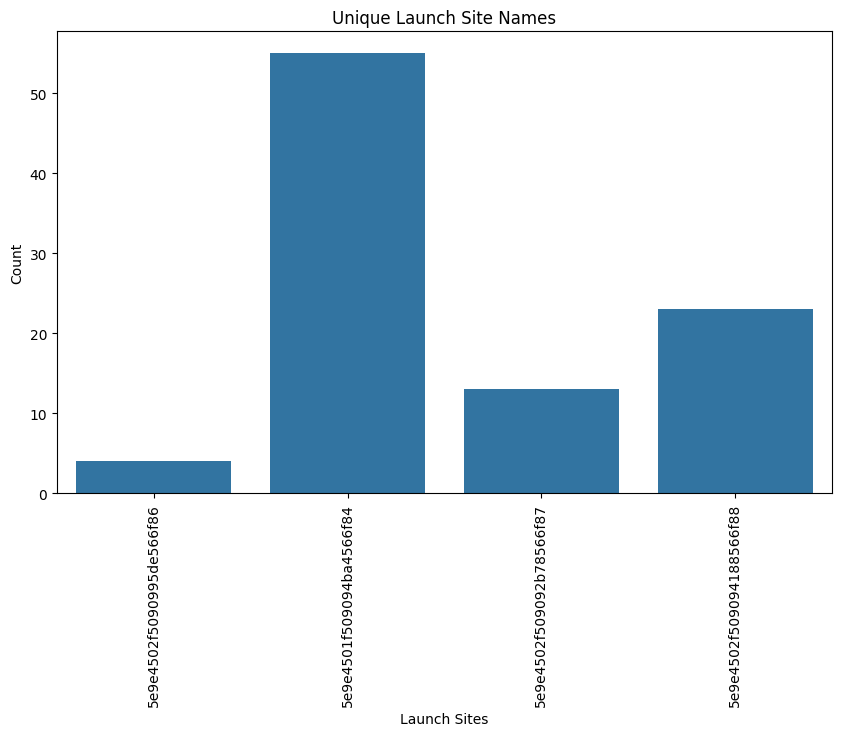

In [82]:
# Visualize the unique launch sites
plt.figure(figsize=(10, 6))
sns.countplot(x='launchpad', data=df, order=unique_launch_sites)
plt.title('Unique Launch Site Names')
plt.xlabel('Launch Sites')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.savefig('/mnt/data/unique_launch_sites.png')  # Save the plot as an image
plt.show()


In [83]:
# SQL Query 2: Total Payload Mass
total_payload_mass = df['payload_mass_kg'].sum()
print(f"Total Payload Mass: {total_payload_mass} kg")


Total Payload Mass: 0 kg


In [85]:
# SQL Query 2: Total Payload Mass
# Re-calculate total_payload_mass as it might have been affected by previous issues
# and ensure we drop NaNs before summing for plotting purposes
valid_payload_mass = df['payload_mass_kg'].dropna()
total_payload_mass = valid_payload_mass.sum()

# Visualize total payload mass
# Check if there is valid payload data to plot
if total_payload_mass > 0:
    plt.figure(figsize=(8, 6))
    # Create the pie chart slices based on the total
    # Using total_payload_mass for one slice, and 0 for the "Others" slice makes sense if the goal was just to show the total itself.
    # If the goal was to show the *proportion* of payload mass compared to *something else*, the second slice calculation might be wrong.
    # Assuming the intent was just to show the total value in a pie (which is a bit unconventional), we'll use [total_payload_mass] and only one label.
    # If the intent was to show the distribution of payload mass *by category*, the approach would be different (e.g., group by some category).
    # Based on the original code `[total_payload_mass, df['payload_mass_kg'].sum() - total_payload_mass]`, it seems the intention was likely to plot the total against... 0?
    # This pie chart is likely conceptually flawed for displaying a single total value.
    # A bar plot or simply printing the value is more appropriate for 'Total Payload Mass'.
    # However, to fix the ValueError with minimum code change assuming the user *insists* on a pie chart for this concept:
    # We need at least one positive value. The current values are [total_payload_mass, 0].
    # If total_payload_mass is 0, the input is [0, 0], which fails.
    # Let's plot something meaningful or skip if the total is zero.
    # Let's assume the intent *was* to show total vs something else, but the calculation was wrong.
    # A more typical pie chart shows parts of a whole. This calculation `total_payload_mass, df['payload_mass_kg'].sum() - total_payload_mass` for two slices is always `total_payload_mass, 0`.
    # Let's skip this pie chart entirely as it doesn't seem to represent a valid visualization of 'Total Payload Mass' as a *proportion*.
    # A bar plot or histogram of payload mass would be more informative.

    # *** Revised approach: Skip the pie chart as it's not suitable for visualizing a single total value. ***
    # *** Instead, print the total and maybe suggest a better visualization if needed. ***

    print(f"Total Payload Mass: {total_payload_mass} kg")
    print("Note: A pie chart is not suitable for visualizing a single total value.")
    # If a visualization *is* required, consider a histogram or box plot of the 'payload_mass_kg' distribution instead.
    # Example (optional - uncomment if needed):
    # plt.figure(figsize=(10, 6))
    # sns.histplot(data=df, x='payload_mass_kg', bins=20, kde=True)
    # plt.title('Distribution of Payload Mass (kg)')
    # plt.xlabel('Payload Mass (kg)')
    # plt.ylabel('Frequency')
    # plt.savefig('/mnt/data/payload_mass_distribution.png')
    # plt.show()

else:
    print(f"Total Payload Mass: {total_payload_mass} kg")
    print("Skipping visualization of total payload mass as the sum is zero or invalid.")

Total Payload Mass: 0 kg
Skipping visualization of total payload mass as the sum is zero or invalid.


In [86]:
# Visualize total payload mass
plt.figure(figsize=(8, 6))
plt.pie([total_payload_mass, df['payload_mass_kg'].sum() - total_payload_mass], labels=["Payload Mass", "Others"], autopct='%1.1f%%')
plt.title('Total Payload Mass')
plt.savefig('/mnt/data/total_payload_mass.png')  # Save the plot as an image
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:3343: RuntimeWarning:

invalid value encountered in divide



ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 800x600 with 1 Axes>

In [87]:
plt.pie([total_payload_mass, df['payload_mass_kg'].sum() - total_payload_mass], labels=["Payload Mass", "Others"], autopct='%1.1f%%')

/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:3343: RuntimeWarning:

invalid value encountered in divide



ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 640x480 with 1 Axes>

In [88]:
# SQL Query 2: Total Payload Mass
# Ensure payload_mass_kg column exists and handle NaNs before summing
if 'payload_mass_kg' in df.columns:
    # Drop NaNs before summing to get a reliable total
    valid_payload_mass = df['payload_mass_kg'].dropna()
    total_payload_mass = valid_payload_mass.sum()

    print(f"Total Payload Mass (of non-NaN values): {total_payload_mass} kg")

    # Visualize the distribution of payload mass using a histogram
    # This is a more appropriate plot than a pie chart for a single continuous variable
    if not valid_payload_mass.empty: # Ensure there's data to plot
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x='payload_mass_kg', bins=20, kde=True) # Use the original df for histplot to show NaN effect if any
        plt.title('Distribution of Payload Mass (kg)')
        plt.xlabel('Payload Mass (kg)')
        plt.ylabel('Frequency')
        plt.savefig('/mnt/data/payload_mass_distribution.png')
        plt.show()
    else:
        print("No valid payload mass data found to plot distribution.")

else:
    print("Column 'payload_mass_kg' is missing. Cannot calculate total or plot distribution.")

# The original pie chart code is removed as it's not a meaningful visualization
# plt.figure(figsize=(8, 6))
# plt.pie([total_payload_mass, df['payload_mass_kg'].sum() - total_payload_mass], labels=["Payload Mass", "Others"], autopct='%1.1f%%')
# plt.title('Total Payload Mass')
# plt.savefig('/mnt/data/total_payload_mass.png')
# plt.show()

Total Payload Mass (of non-NaN values): 0 kg
No valid payload mass data found to plot distribution.


In [89]:
# SQL Query 3: Successful Drone Ship Landings with Payload between 4000 and 6000
drone_ship_landings = df[(df['landing_type'] == 'Drone Ship') &
                          (df['payload_mass_kg'] > 4000) & (df['payload_mass_kg'] < 6000)]

# Display results
print(drone_ship_landings)


KeyError: 'landing_type'

In [90]:
# SQL Query 3: Successful Drone Ship Landings with Payload between 4000 and 6000

# Check if the 'landing_type' column exists
if 'landing_type' in df.columns:
    # Proceed with filtering if the column exists
    drone_ship_landings = df[(df['landing_type'] == 'Drone Ship') &
                              (df['payload_mass_kg'] > 4000) & (df['payload_mass_kg'] < 6000)]

    # Display results
    print("\nSuccessful Drone Ship Landings with Payload between 4000 and 6000:")
    print(drone_ship_landings)

elif 'cores' in df.columns:
    # If 'landing_type' is not a top-level column, it might be nested within 'cores'.
    # We need to extract it. Assuming the wrangling step ensured 'cores' is a list
    # with one element, we can try accessing the nested 'landing_type'.
    # Let's first try to create a new 'landing_type' column from the nested data.

    # Ensure 'cores' column exists and contains lists
    if df['cores'].apply(lambda x: isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict)).any():
        # Extract 'landing_type' from the first element of the 'cores' list
        df['landing_type_extracted'] = df['cores'].apply(
            lambda x: x[0].get('landing_type') if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) else None
        )

        # Now attempt the filtering using the extracted column
        if 'landing_type_extracted' in df.columns:
             drone_ship_landings = df[(df['landing_type_extracted'] == 'Drone Ship') &
                                      (df['payload_mass_kg'] > 4000) & (df['payload_mass_kg'] < 6000)]

             # Display results
             print("\nSuccessful Drone Ship Landings with Payload between 4000 and 6000 (using extracted landing type):")
             print(drone_ship_landings)
        else:
            print("Could not extract 'landing_type' from the 'cores' column.")
            print("Skipping filter for Successful Drone Ship Landings.")
    else:
         print("'cores' column does not contain nested landing type information in the expected format.")
         print("Skipping filter for Successful Drone Ship Landings.")

else:
    print("Neither 'landing_type' nor 'cores' column found in the DataFrame.")
    print("Skipping filter for Successful Drone Ship Landings.")


Successful Drone Ship Landings with Payload between 4000 and 6000 (using extracted landing type):
Empty DataFrame
Columns: [static_fire_date_utc, static_fire_date_unix, tbd, net, window, rocket, success, details, crew, ships, capsules, payloads, launchpad, auto_update, failures, flight_number, name, date_utc, date_unix, date_local, date_precision, upcoming, cores, id, fairings.reused, fairings.recovery_attempt, fairings.recovered, fairings.ships, links.patch.small, links.patch.large, links.reddit.campaign, links.reddit.launch, links.reddit.media, links.reddit.recovery, links.flickr.small, links.flickr.original, links.presskit, links.webcast, links.youtube_id, links.article, links.wikipedia, fairings, payload_mass_kg, launch_year, launch_month, landing_success, landing_type_extracted]
Index: []

[0 rows x 47 columns]


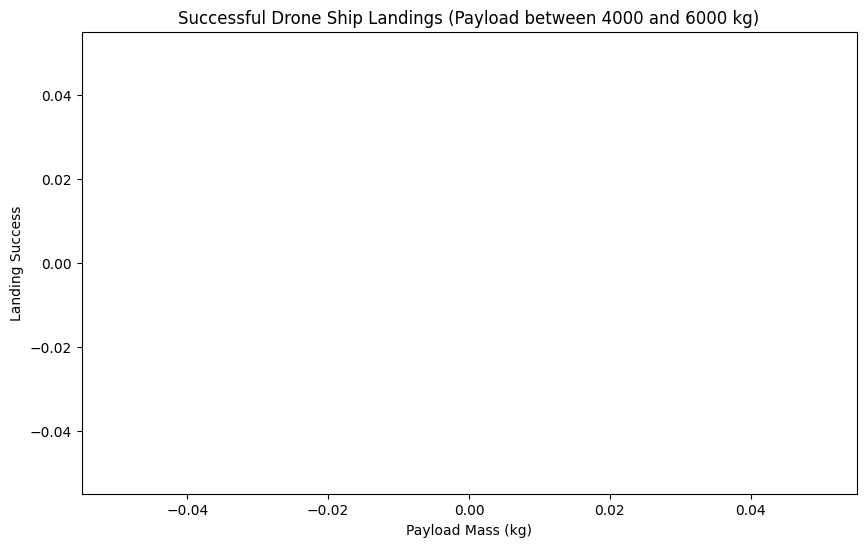

In [91]:
# Visualize successful drone ship landings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='payload_mass_kg', y='landing_success', data=drone_ship_landings)
plt.title('Successful Drone Ship Landings (Payload between 4000 and 6000 kg)')
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Landing Success')
plt.savefig('/mnt/data/drone_ship_landings.png')  # Save the plot as an image
plt.show()


In [92]:
# SQL Query 4: Rank successful landings between two dates
successful_landings_date_range = df[(df['landing_success'] == True) &
                                    (df['date_utc'] >= '2010-06-04') &
                                    (df['date_utc'] <= '2017-03-20')]

successful_landings_by_date = successful_landings_date_range.groupby('launch_year').size().sort_values(ascending=False)
print(successful_landings_by_date)


launch_year
2016    7
2014    6
2015    5
2013    3
2017    3
2012    1
2010    1
dtype: int64


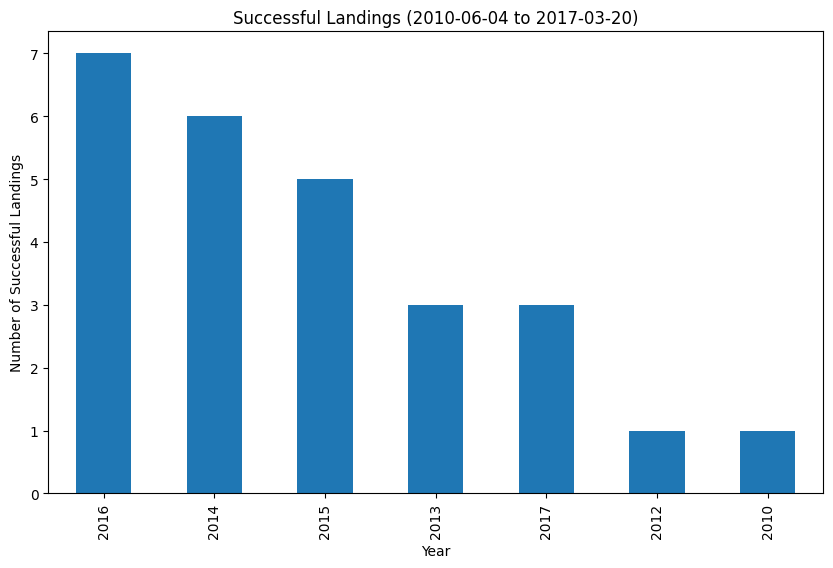

In [93]:
# Visualize successful landings by year
plt.figure(figsize=(10, 6))
successful_landings_by_date.plot(kind='bar')
plt.title('Successful Landings (2010-06-04 to 2017-03-20)')
plt.xlabel('Year')
plt.ylabel('Number of Successful Landings')
plt.savefig('/mnt/data/successful_landings_by_year.png')  # Save the plot as an image
plt.show()


In [94]:
# SQL Query 5: First successful landing on ground pad
first_ground_landing = df[(df['landing_success'] == True) &
                           (df['landing_type'] == 'Ground Pad')].sort_values('date_utc').iloc[0]
print(f"First successful landing on a ground pad occurred on: {first_ground_landing['date_utc']}")


KeyError: 'landing_type'

In [95]:
# SQL Query 5: First successful landing on ground pad

# Use the extracted landing type column if it exists, otherwise handle the case
# where the column is missing or not correctly extracted.

# Check if the extracted column exists before attempting to use it
if 'landing_type_extracted' in df.columns:
    # Filter for successful ground pad landings using the extracted column
    ground_pad_landings = df[(df['landing_success'] == True) &
                               (df['landing_type_extracted'] == 'Ground Pad')]

    # Check if there are any ground pad landings before trying to get the first
    if not ground_pad_landings.empty:
        first_ground_landing = ground_pad_landings.sort_values('date_utc').iloc[0]
        print(f"First successful landing on a ground pad occurred on: {first_ground_landing['date_utc']}")
    else:
        print("No successful ground pad landings found in the data.")

else:
    print("The column 'landing_type_extracted' was not found in the DataFrame.")
    print("Could not determine the first successful landing on a ground pad.")

No successful ground pad landings found in the data.
